# Model Training

In [1]:
# Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

from lime import lime_image
from skimage.segmentation import mark_boundaries

import optuna

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from torch.utils.data import random_split

from torchviz import make_dot
from IPython.display import Image

/Users/bashirahmadgulistani/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [38]:
# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001


transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),      
    transforms.Normalize((0.5,), (0.5,))
])


In [40]:
'''

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # image size
        self.fc2 = nn.Linear(128, 3)  # 3 output classes 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

'''
            
            
            
'''        
def train_model(model, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to('cpu'), labels.to('cpu')

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


def visualize_predictions(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to('cpu'), labels.to('cpu')
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) 
        plt.title(f"True: {labels[i].item()}, Pred: {predicted[i].item()}")
        plt.axis('off')
    plt.show()

    
    
#######

def evaluate_model(model, test_loader, num_classes, device='cpu'):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1) 
            _, predicted = torch.max(outputs, 1)  
            
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    if num_classes > 2:
        roc_auc = roc_auc_score(y_true, y_scores, average='macro', multi_class='ovr')
    else:
        roc_auc = roc_auc_score(y_true, y_scores[:, 1])

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc
    }
'''

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        correct, total, epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss.append(epoch_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

# Plot training progress
def plot_training_progress(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.tight_layout()
    plt.show()




    
######

def evaluate_model(model, loader, num_classes):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            y_scores.extend(probabilities.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    return y_true, y_scores

# Plot ROC curve for each class
def plot_multi_class_roc(y_true, y_scores, num_classes, class_names):
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-Class ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall curve for each class
def plot_multi_class_precision_recall(y_true, y_scores, num_classes, class_names):
    plt.figure()
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
        avg_precision = average_precision_score(y_true == i, y_scores[:, i])
        plt.plot(recall, precision, label=f"{class_names[i]} (AP = {avg_precision:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multi-Class Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.show()
    

class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  
        self.fc2 = nn.Linear(128, 3)  # 3 output classes
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x    

def objective(trial):
    # Hyperparameter space
    learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.7)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Data preparation
    transform = transforms.Compose([
        transforms.Resize((64, 64)), 
        transforms.ToTensor(),      
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    train_dataset = datasets.ImageFolder(root='syn_img', transform=transform)
    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    # Model initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout_rate).to(device)
    model.apply(init_weights)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Training
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
# Datasets: All Original Images

train_dataset = datasets.ImageFolder(root='train', transform=transform)  
test_dataset = datasets.ImageFolder(root='test', transform=transform)   

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Epoch 1/20, Train Loss: 1.5448, Val Loss: 0.8709, Train Acc: 0.4091, Val Acc: 0.5455
Epoch 2/20, Train Loss: 0.7922, Val Loss: 0.6527, Train Acc: 0.6500, Val Acc: 0.8000
Epoch 3/20, Train Loss: 0.5308, Val Loss: 0.3844, Train Acc: 0.8500, Val Acc: 0.9091
Epoch 4/20, Train Loss: 0.3153, Val Loss: 0.3181, Train Acc: 0.8818, Val Acc: 0.9273
Epoch 5/20, Train Loss: 0.2214, Val Loss: 0.2619, Train Acc: 0.9227, Val Acc: 0.9455
Epoch 6/20, Train Loss: 0.1584, Val Loss: 0.2930, Train Acc: 0.9455, Val Acc: 0.9455
Epoch 7/20, Train Loss: 0.1359, Val Loss: 0.3271, Train Acc: 0.9500, Val Acc: 0.9273
Epoch 8/20, Train Loss: 0.0604, Val Loss: 0.3247, Train Acc: 0.9773, Val Acc: 0.9455
Epoch 9/20, Train Loss: 0.0721, Val Loss: 0.2688, Train Acc: 0.9864, Val Acc: 0.9455
Epoch 10/20, Train Loss: 0.0724, Val Loss: 0.2815, Train Acc: 0.9773, Val Acc: 0.9455
Epoch 11/20, Train Loss: 0.0532, Val Loss: 0.2202, Train Acc: 0.9864, Val Acc: 0.9455
Epoch 12/20, Train Loss: 0.0488, Val Loss: 0.2735, Train Acc: 0

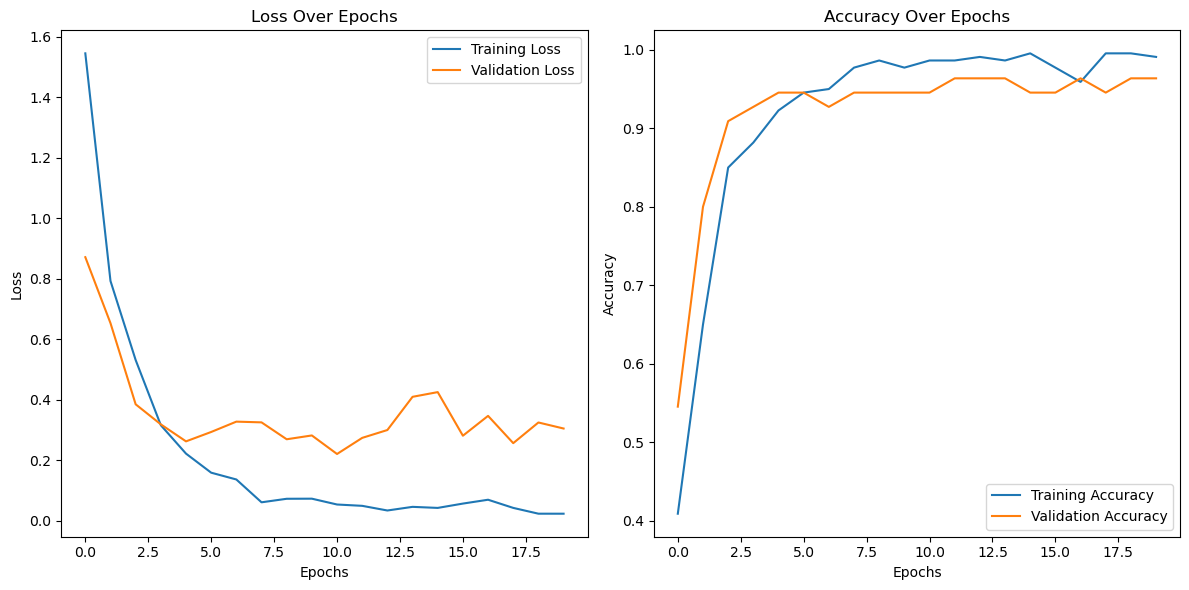

In [14]:
### Model 1
device = 'cpu'
# Model, loss, and optimizer
model = CNN().to(device)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=num_epochs)

plot_training_progress(train_loss, val_loss, train_acc, val_acc)

In [41]:
# Evaluate the model
metrics = evaluate_model(model, test_loader, num_classes=3)
print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics:
Accuracy: 0.9636
Precision: 0.9655
Recall: 0.9636
F1-score: 0.9630
ROC-AUC: 0.9865


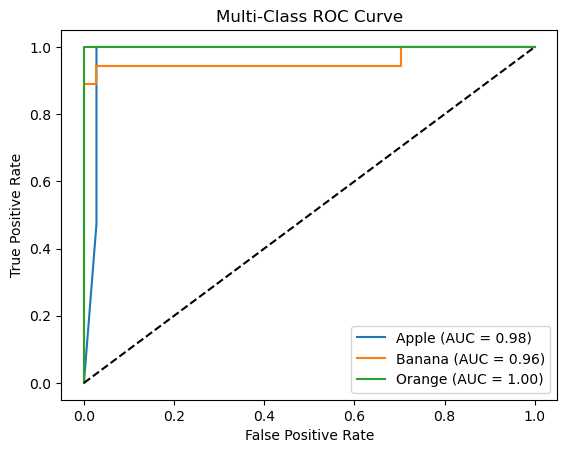

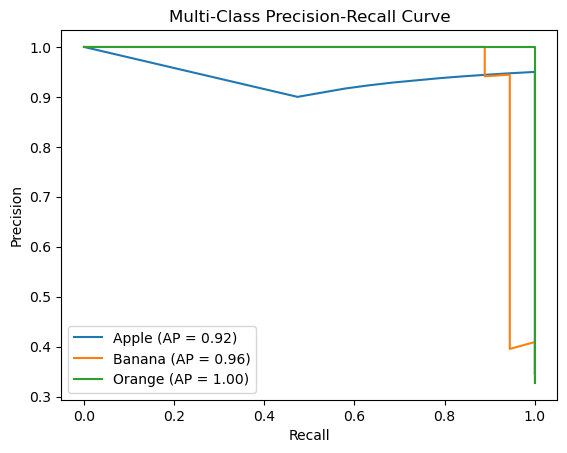

In [22]:
class_names = ["Apple", "Banana", "Orange"]

y_true, y_scores = evaluate_model(model, test_loader, num_classes=len(class_names))

plot_multi_class_roc(y_true, y_scores, num_classes=len(class_names), class_names=class_names)
plot_multi_class_precision_recall(y_true, y_scores, num_classes=len(class_names), class_names=class_names)


In [6]:
# Datasets: All Synthetic Images

train_dataset2 = datasets.ImageFolder(root='syn_img', transform=transform)   
train_loader2 = DataLoader(dataset=train_dataset2, batch_size=batch_size, shuffle=True)


Epoch 1/20, Train Loss: 1.2031, Val Loss: 1.9372, Train Acc: 0.4433, Val Acc: 0.3455
Epoch 2/20, Train Loss: 0.5881, Val Loss: 3.4112, Train Acc: 0.8200, Val Acc: 0.5091
Epoch 3/20, Train Loss: 0.2531, Val Loss: 2.8855, Train Acc: 0.9267, Val Acc: 0.6364
Epoch 4/20, Train Loss: 0.1378, Val Loss: 2.1523, Train Acc: 0.9500, Val Acc: 0.6000
Epoch 5/20, Train Loss: 0.1006, Val Loss: 3.3520, Train Acc: 0.9700, Val Acc: 0.6000
Epoch 6/20, Train Loss: 0.0785, Val Loss: 2.7614, Train Acc: 0.9700, Val Acc: 0.7091
Epoch 7/20, Train Loss: 0.0493, Val Loss: 3.7198, Train Acc: 0.9867, Val Acc: 0.7273
Epoch 8/20, Train Loss: 0.0273, Val Loss: 3.2923, Train Acc: 0.9967, Val Acc: 0.7273
Epoch 9/20, Train Loss: 0.0184, Val Loss: 2.8410, Train Acc: 0.9967, Val Acc: 0.7091
Epoch 10/20, Train Loss: 0.0143, Val Loss: 3.3480, Train Acc: 0.9967, Val Acc: 0.6909
Epoch 11/20, Train Loss: 0.0176, Val Loss: 5.2499, Train Acc: 0.9933, Val Acc: 0.5636
Epoch 12/20, Train Loss: 0.0210, Val Loss: 3.4633, Train Acc: 0

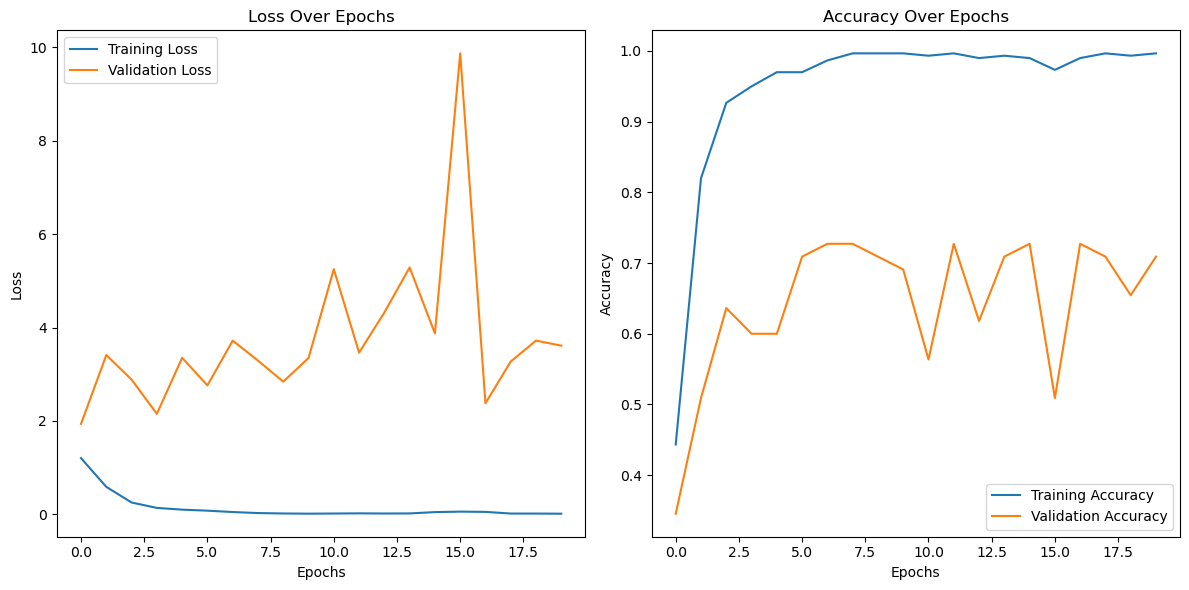

In [41]:
# Model 2

device = 'cpu'
model2 = CNN().to(device)
model2.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(model2, train_loader2, test_loader, criterion, optimizer, epochs=num_epochs)

plot_training_progress(train_loss, val_loss, train_acc, val_acc)

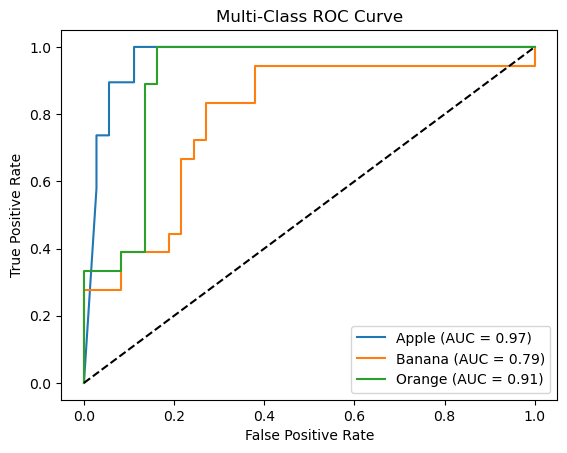

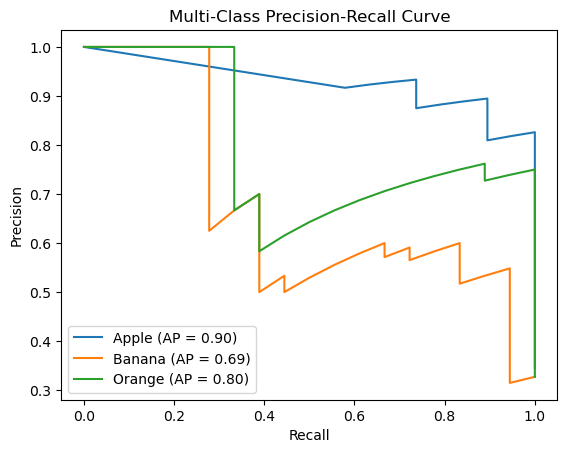

In [42]:
class_names = ["Apple", "Banana", "Orange"]

y_true, y_scores = evaluate_model(model2, test_loader, num_classes=len(class_names))

plot_multi_class_roc(y_true, y_scores, num_classes=len(class_names), class_names=class_names)
plot_multi_class_precision_recall(y_true, y_scores, num_classes=len(class_names), class_names=class_names)


In [32]:
# Tuning

# Hyperparameter Tuning:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)

[I 2024-12-01 17:49:19,992] A new study created in memory with name: no-name-ecfddb79-205d-4f58-87a0-88c6bd8ef8f3
/var/folders/v2/j9hfmn2j2vb59z0wl50rtltm0000gn/T/ipykernel_3839/1634846140.py:257: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/var/folders/v2/j9hfmn2j2vb59z0wl50rtltm0000gn/T/ipykernel_3839/1634846140.py:259: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.7)
[I 2024-12-01 17:49:45,331] Trial 0 finished with value: 0.45 and parameters: {'lr': 0.00027989496839970205, 'optimizer': 'SGD', 'dropout_rate': 0.37962275607502105, 'batch_size': 128}. Best is trial 0 

[I 2024-12-01 18:03:23,028] Trial 31 finished with value: 0.9 and parameters: {'lr': 0.002900153452647415, 'optimizer': 'SGD', 'dropout_rate': 0.23872243613071822, 'batch_size': 16}. Best is trial 4 with value: 0.9833333333333333.
[I 2024-12-01 18:03:49,188] Trial 32 finished with value: 0.9666666666666667 and parameters: {'lr': 0.002756341074594653, 'optimizer': 'SGD', 'dropout_rate': 0.20127848684887054, 'batch_size': 16}. Best is trial 4 with value: 0.9833333333333333.
[I 2024-12-01 18:04:15,392] Trial 33 finished with value: 0.9333333333333333 and parameters: {'lr': 0.007229899715498689, 'optimizer': 'SGD', 'dropout_rate': 0.23610899359737, 'batch_size': 16}. Best is trial 4 with value: 0.9833333333333333.
[I 2024-12-01 18:04:41,761] Trial 34 finished with value: 0.95 and parameters: {'lr': 0.005166234220878676, 'optimizer': 'SGD', 'dropout_rate': 0.24482982711065096, 'batch_size': 16}. Best is trial 4 with value: 0.9833333333333333.
[I 2024-12-01 18:05:08,106] Trial 35 finished wi

Best hyperparameters: {'lr': 0.00034200457690912835, 'optimizer': 'Adam', 'dropout_rate': 0.31722634344248496, 'batch_size': 64}
Best validation accuracy: 0.9833333333333333


In [44]:
# Evaluate the model
metrics = evaluate_model(model2, test_loader, num_classes=3)
print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
Accuracy: 0.7091
Precision: 0.7807
Recall: 0.7091
F1-score: 0.6802
ROC-AUC: 0.8906


Epoch 1/10, Train Loss: 1.0715, Val Loss: 1.1596, Train Acc: 0.4300, Val Acc: 0.4182
Epoch 2/10, Train Loss: 0.8312, Val Loss: 1.8212, Train Acc: 0.6500, Val Acc: 0.4000
Epoch 3/10, Train Loss: 0.5020, Val Loss: 1.8266, Train Acc: 0.8667, Val Acc: 0.4545
Epoch 4/10, Train Loss: 0.3240, Val Loss: 2.3067, Train Acc: 0.8967, Val Acc: 0.5455
Epoch 5/10, Train Loss: 0.2749, Val Loss: 1.9003, Train Acc: 0.9033, Val Acc: 0.6909
Epoch 6/10, Train Loss: 0.1962, Val Loss: 0.9845, Train Acc: 0.9300, Val Acc: 0.7273
Epoch 7/10, Train Loss: 0.1510, Val Loss: 1.3408, Train Acc: 0.9633, Val Acc: 0.7273
Epoch 8/10, Train Loss: 0.0981, Val Loss: 1.8550, Train Acc: 0.9867, Val Acc: 0.7091
Epoch 9/10, Train Loss: 0.1112, Val Loss: 1.3549, Train Acc: 0.9633, Val Acc: 0.7273
Epoch 10/10, Train Loss: 0.0790, Val Loss: 2.0288, Train Acc: 0.9800, Val Acc: 0.7091


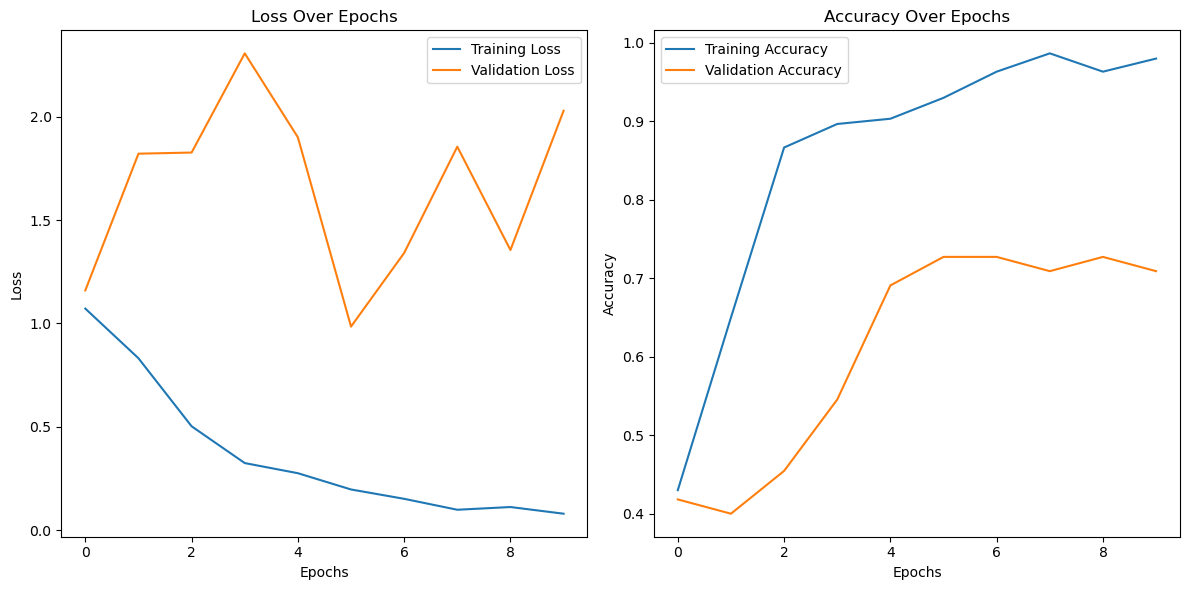

In [37]:
# Post Hyperparameter Tuning

class CNN(nn.Module):
    def __init__(self, num_filters=32, dropout_rate=0.5, num_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(num_filters * 2 * 16 * 16, 128)  # Adjust to match your input size
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        correct, total, epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(epoch_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc




best_params = {'learning_rate': 0.00034200457690912835, 'optimizer': 'Adam', 'dropout_rate': 0.31722634344248496, 'batch_size': 64, 'num_filters':32, 'epochs':10}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(dropout_rate=best_params['dropout_rate'], num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader2, test_loader, criterion, optimizer, device, epochs=best_params['epochs']
)

#torch.save(model.state_dict(), "best_cnn_model.pth")

plot_training_progress(train_loss, val_loss, train_acc, val_acc)


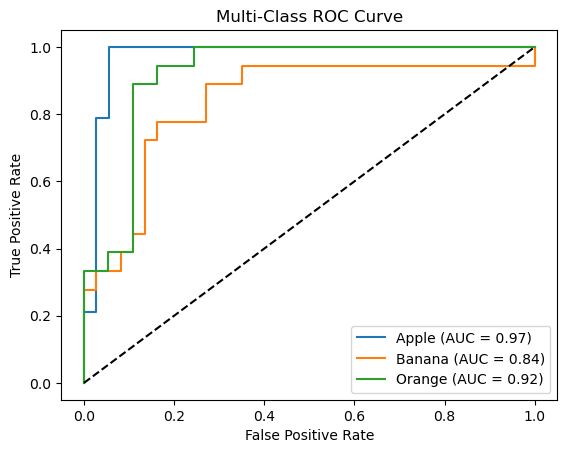

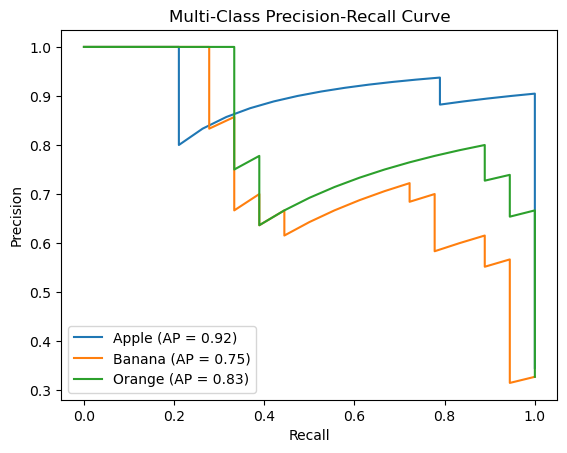

In [43]:
class_names = ["Apple", "Banana", "Orange"]

y_true, y_scores = evaluate_model(model, test_loader, num_classes=len(class_names))

plot_multi_class_roc(y_true, y_scores, num_classes=len(class_names), class_names=class_names)
plot_multi_class_precision_recall(y_true, y_scores, num_classes=len(class_names), class_names=class_names)

In [8]:
# Datasets: Synthetic Images 50% Original 50%

syn_img_path = 'syn_img'
original_img_path = 'train'

synthetic_dataset = datasets.ImageFolder(root=syn_img_path, transform=transform)
original_dataset = datasets.ImageFolder(root=original_img_path, transform=transform)

def get_class_indices(dataset):
    """Return a dictionary with class indices grouped by category."""
    class_indices = {class_name: [] for class_name in dataset.classes}
    for idx, (_, label) in enumerate(dataset.samples):
        class_name = dataset.classes[label]
        class_indices[class_name].append(idx)
    return class_indices

synthetic_indices = get_class_indices(synthetic_dataset)
original_indices = get_class_indices(original_dataset)

def sample_indices(synthetic_indices, original_indices, syn_ratio=0.5, orig_ratio=0.5):
    combined_indices = []
    for category in synthetic_indices.keys():
        syn_count = int(len(synthetic_indices[category]) * syn_ratio)
        orig_count = int(len(original_indices[category]) * orig_ratio)

        syn_sample = random.sample(synthetic_indices[category], min(syn_count, len(synthetic_indices[category])))
        orig_sample = random.sample(original_indices[category], min(orig_count, len(original_indices[category])))

        combined_indices.extend(syn_sample + orig_sample)

    return combined_indices

combined_indices = sample_indices(synthetic_indices, original_indices)


combined_dataset = Subset(synthetic_dataset + original_dataset, combined_indices)
train_loader3 = DataLoader(combined_dataset, batch_size=32, shuffle=True)



Epoch 1/20, Train Loss: 1.0881, Val Loss: 1.8055, Train Acc: 0.4556, Val Acc: 0.4545
Epoch 2/20, Train Loss: 0.5415, Val Loss: 4.5865, Train Acc: 0.8147, Val Acc: 0.6182
Epoch 3/20, Train Loss: 0.3544, Val Loss: 2.5157, Train Acc: 0.8417, Val Acc: 0.6727
Epoch 4/20, Train Loss: 0.1611, Val Loss: 2.6570, Train Acc: 0.9421, Val Acc: 0.5455
Epoch 5/20, Train Loss: 0.0933, Val Loss: 2.5964, Train Acc: 0.9768, Val Acc: 0.5636
Epoch 6/20, Train Loss: 0.0771, Val Loss: 1.7256, Train Acc: 0.9691, Val Acc: 0.7455
Epoch 7/20, Train Loss: 0.0391, Val Loss: 3.2794, Train Acc: 0.9923, Val Acc: 0.7455
Epoch 8/20, Train Loss: 0.0274, Val Loss: 2.1619, Train Acc: 0.9923, Val Acc: 0.7455
Epoch 9/20, Train Loss: 0.0170, Val Loss: 3.4195, Train Acc: 0.9961, Val Acc: 0.6909
Epoch 10/20, Train Loss: 0.0158, Val Loss: 3.9047, Train Acc: 0.9923, Val Acc: 0.7273
Epoch 11/20, Train Loss: 0.0140, Val Loss: 4.0564, Train Acc: 0.9961, Val Acc: 0.7455
Epoch 12/20, Train Loss: 0.0146, Val Loss: 4.2421, Train Acc: 0

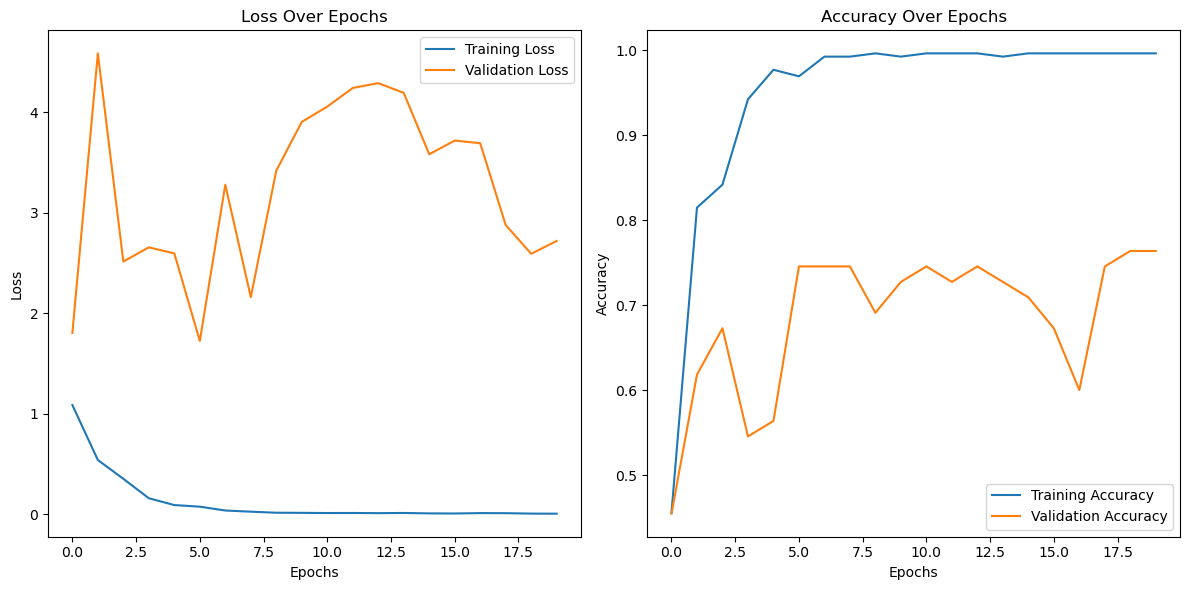

In [12]:
# Model 3

device = 'cpu'
model3 = CNN().to(device)
model3.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(model3, train_loader3, test_loader, criterion, optimizer, epochs=num_epochs)

plot_training_progress(train_loss, val_loss, train_acc, val_acc)

In [47]:
# Evaluate the model
metrics = evaluate_model(model3, test_loader, num_classes=3)
print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics:
Accuracy: 0.7455
Precision: 0.7734
Recall: 0.7455
F1-score: 0.7120
ROC-AUC: 0.8746


In [29]:
# 70% Synthetic 30% Original

combined_indices = sample_indices(synthetic_indices, original_indices, syn_ratio=0.7, orig_ratio=0.3)

combined_dataset = Subset(synthetic_dataset + original_dataset, combined_indices)
train_loader4 = DataLoader(combined_dataset, batch_size=32, shuffle=True)

Epoch 1/20, Train Loss: 1.2740, Val Loss: 1.8645, Train Acc: 0.4197, Val Acc: 0.3636
Epoch 2/20, Train Loss: 0.6677, Val Loss: 3.7198, Train Acc: 0.7993, Val Acc: 0.4182
Epoch 3/20, Train Loss: 0.3084, Val Loss: 5.1724, Train Acc: 0.8942, Val Acc: 0.4000
Epoch 4/20, Train Loss: 0.1621, Val Loss: 4.4885, Train Acc: 0.9380, Val Acc: 0.6727
Epoch 5/20, Train Loss: 0.0856, Val Loss: 1.6551, Train Acc: 0.9708, Val Acc: 0.6545
Epoch 6/20, Train Loss: 0.0880, Val Loss: 4.3872, Train Acc: 0.9745, Val Acc: 0.6545
Epoch 7/20, Train Loss: 0.0316, Val Loss: 2.2760, Train Acc: 0.9927, Val Acc: 0.6000
Epoch 8/20, Train Loss: 0.0291, Val Loss: 4.1028, Train Acc: 0.9927, Val Acc: 0.6000
Epoch 9/20, Train Loss: 0.0277, Val Loss: 6.1034, Train Acc: 0.9927, Val Acc: 0.6000
Epoch 10/20, Train Loss: 0.0231, Val Loss: 5.3820, Train Acc: 0.9927, Val Acc: 0.6545
Epoch 11/20, Train Loss: 0.0153, Val Loss: 4.4954, Train Acc: 1.0000, Val Acc: 0.6909
Epoch 12/20, Train Loss: 0.0162, Val Loss: 5.7383, Train Acc: 0

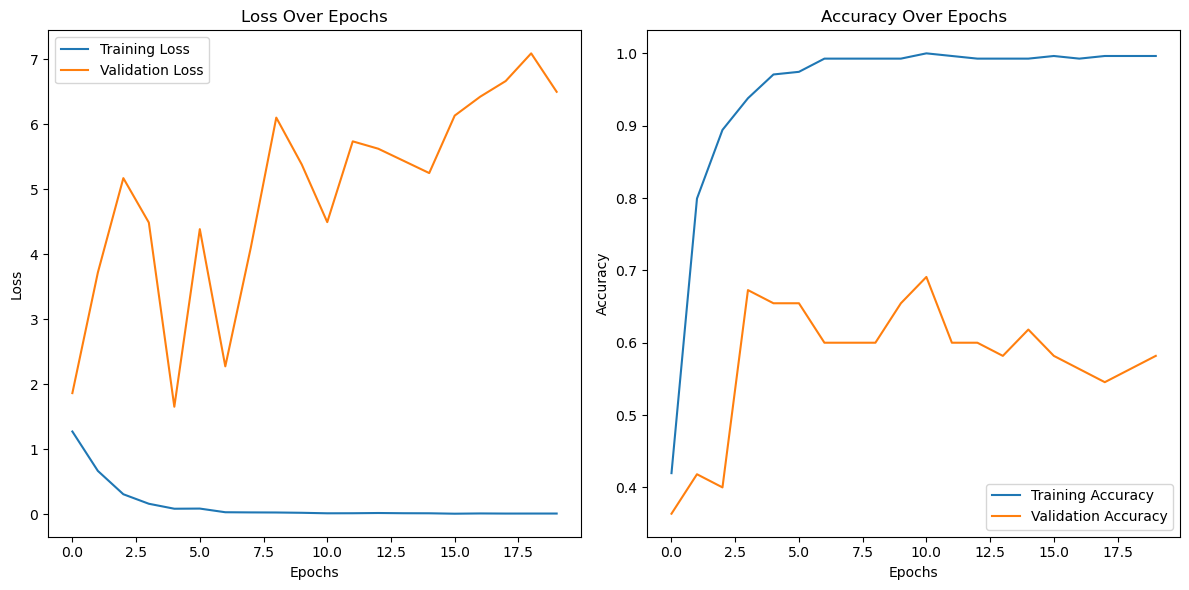

In [30]:
# Model 4:

device = 'cpu'
model4 = CNN().to(device)
model4.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(model4, train_loader4, test_loader, criterion, optimizer, epochs=num_epochs)

plot_training_progress(train_loss, val_loss, train_acc, val_acc)

In [50]:
# Evaluate the model
metrics = evaluate_model(model4, test_loader, num_classes=3)
print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics:
Accuracy: 0.7455
Precision: 0.8243
Recall: 0.7455
F1-score: 0.7044
ROC-AUC: 0.9161


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


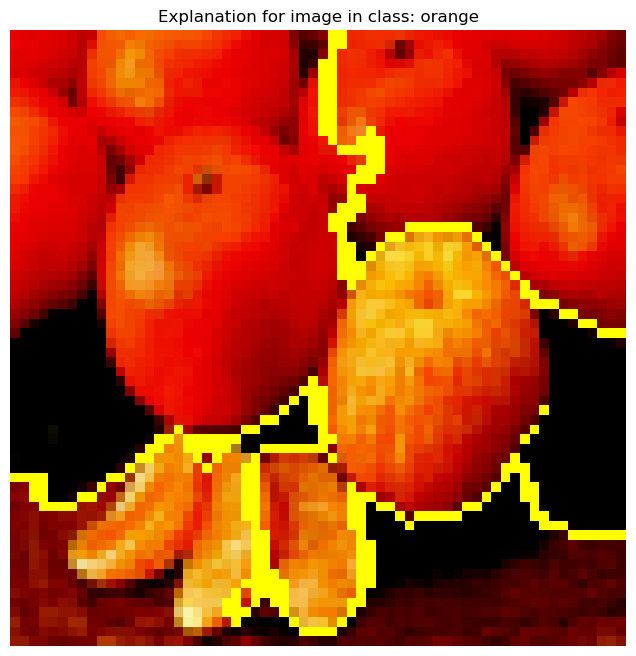

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


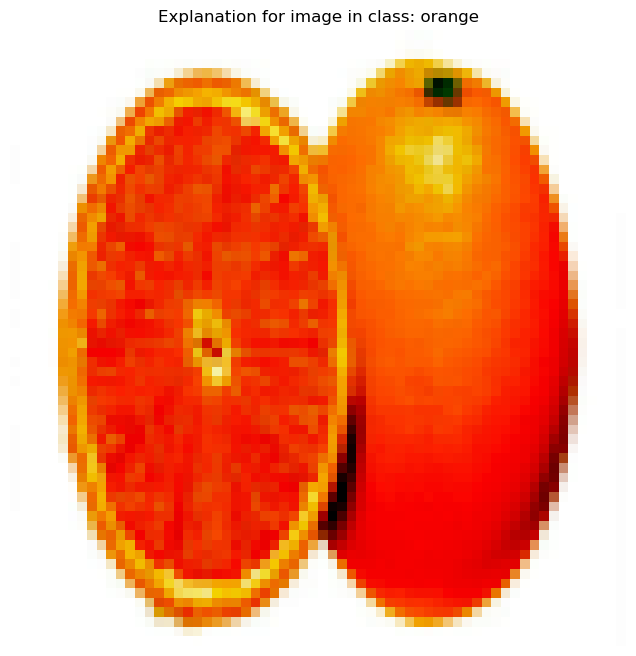

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


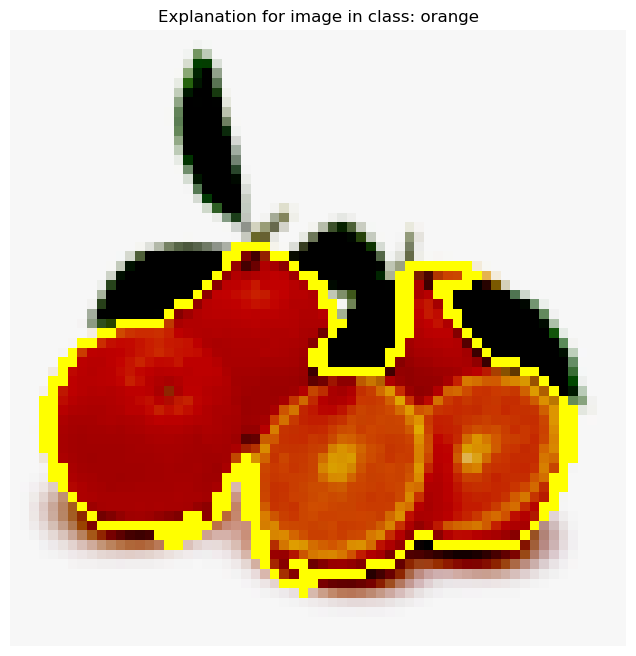

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


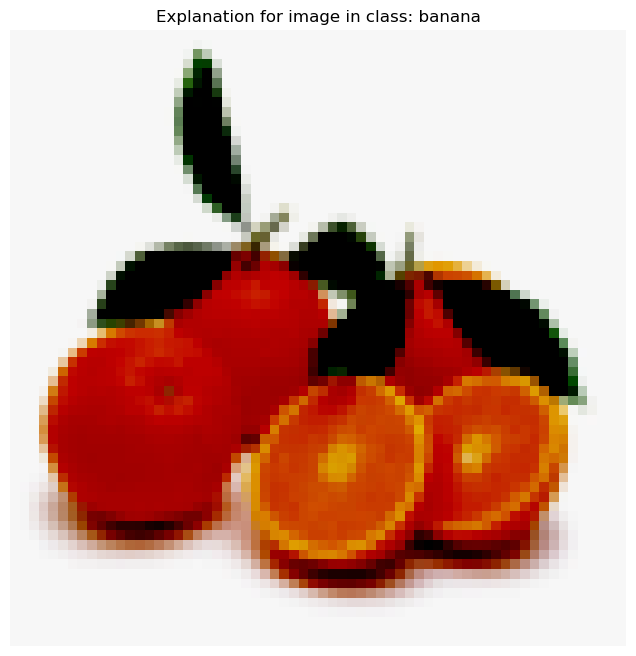

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


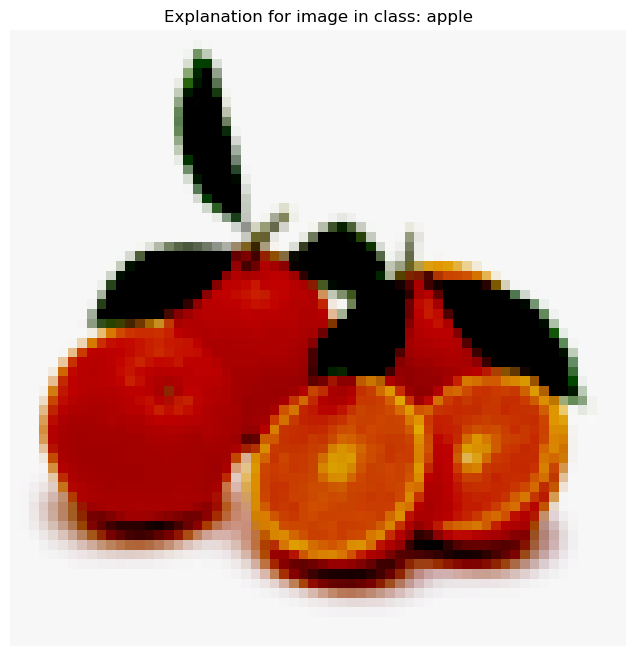

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


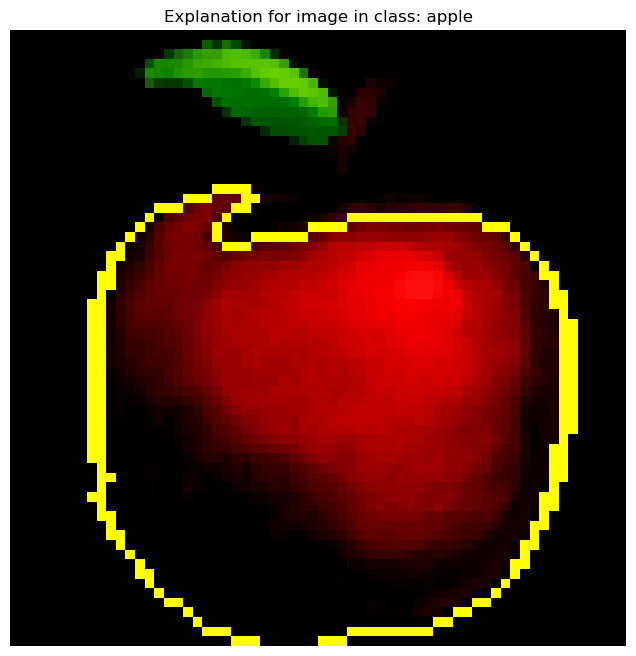

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


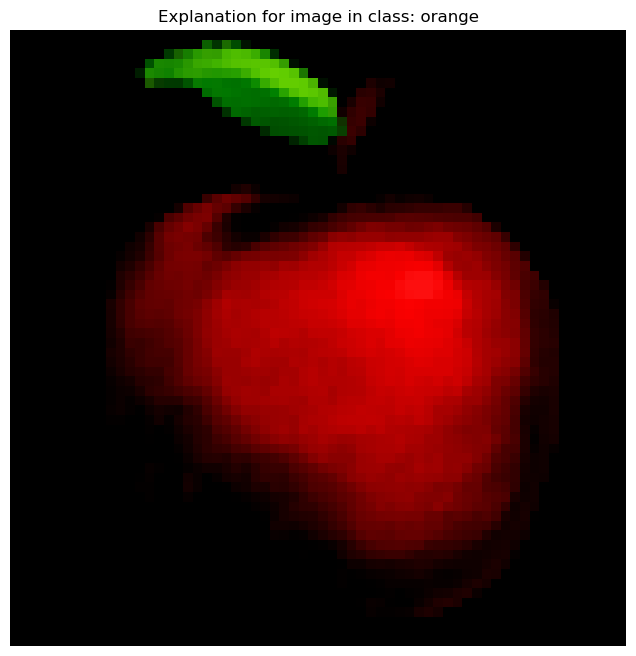

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


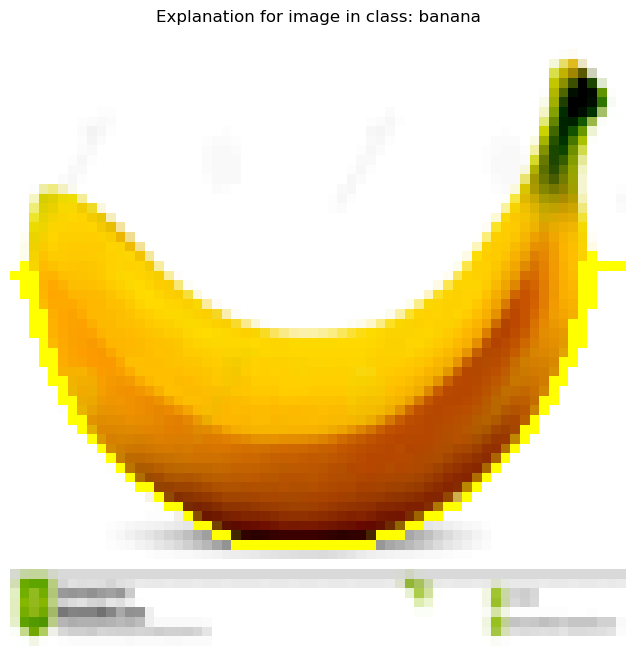

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


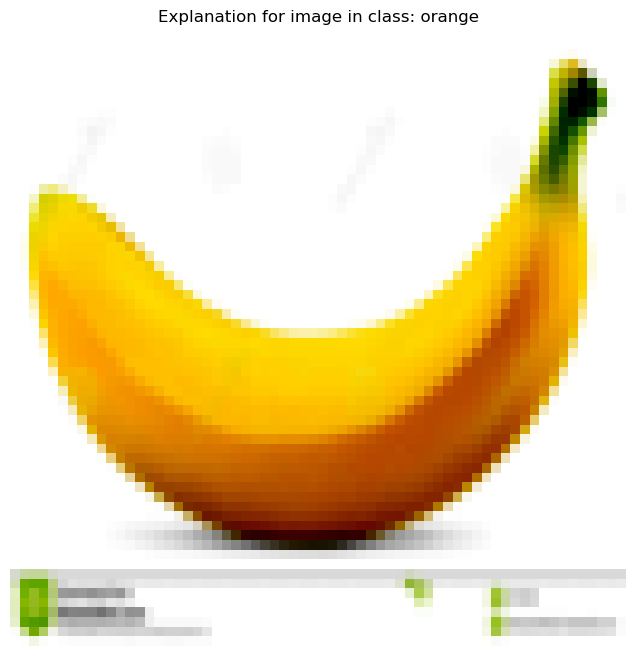

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


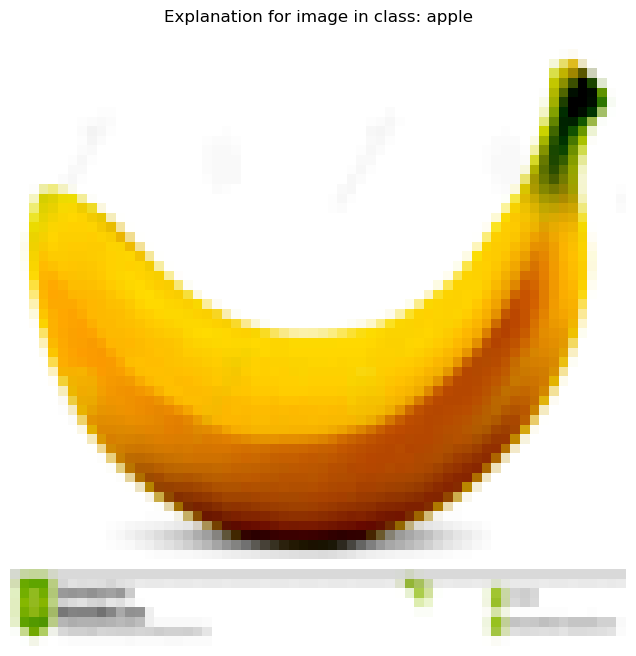

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


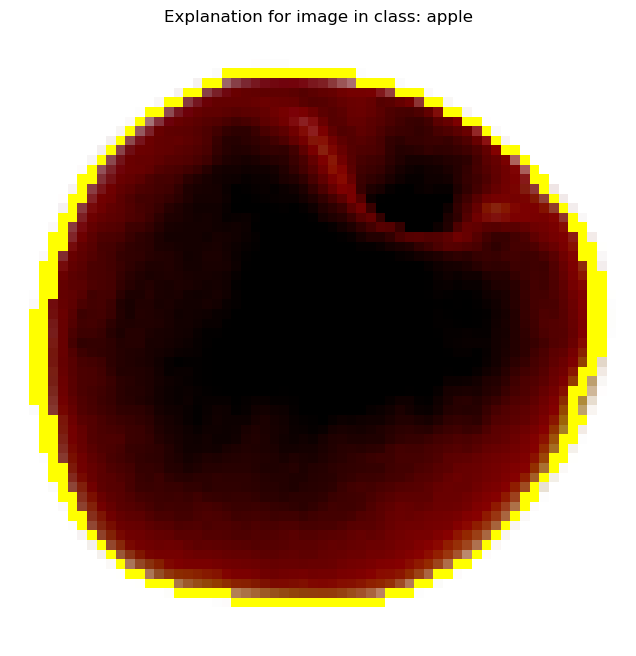

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


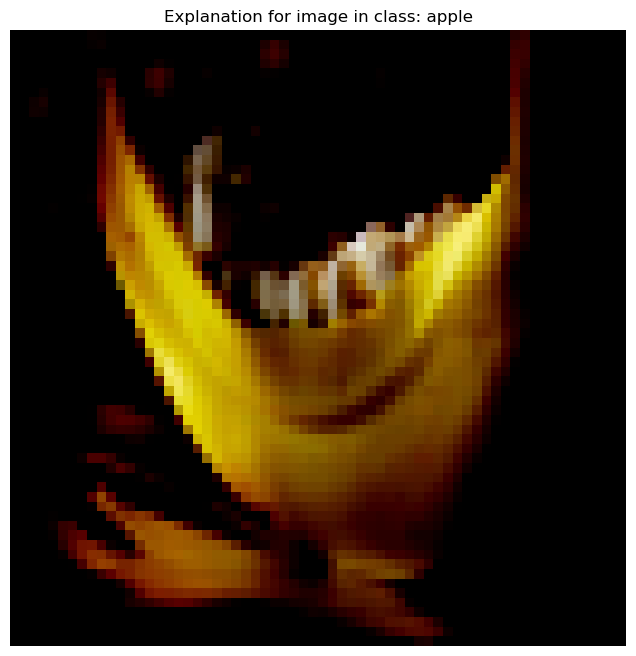

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


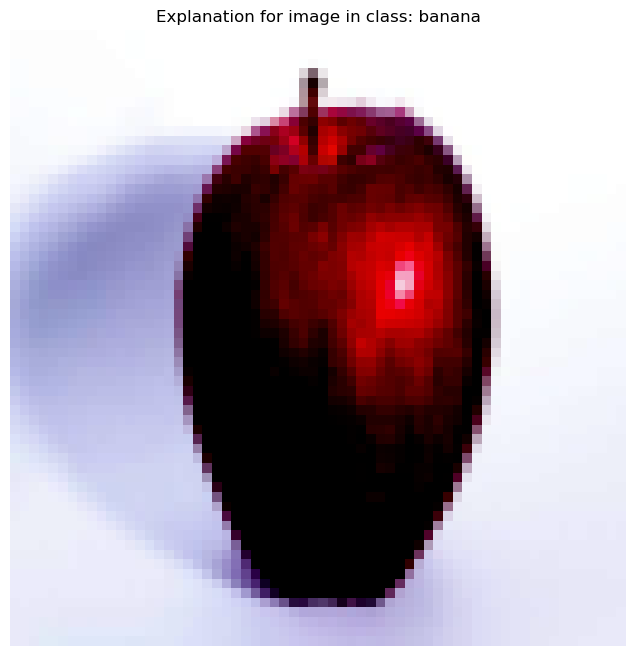

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


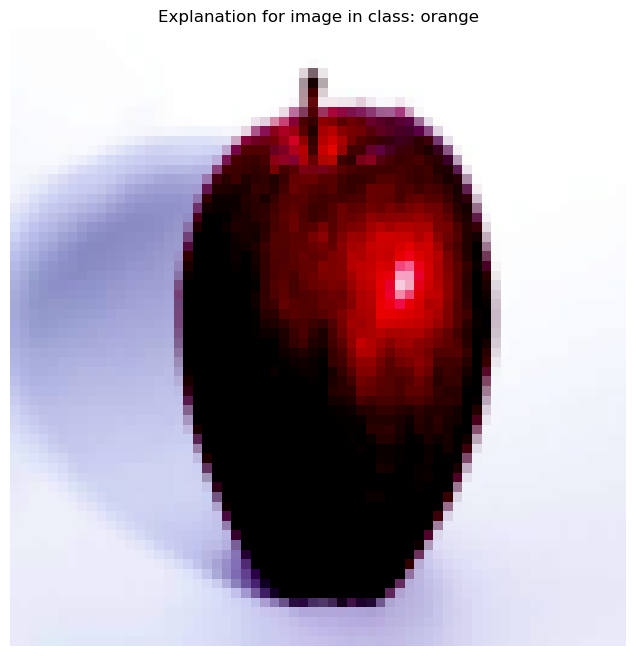

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


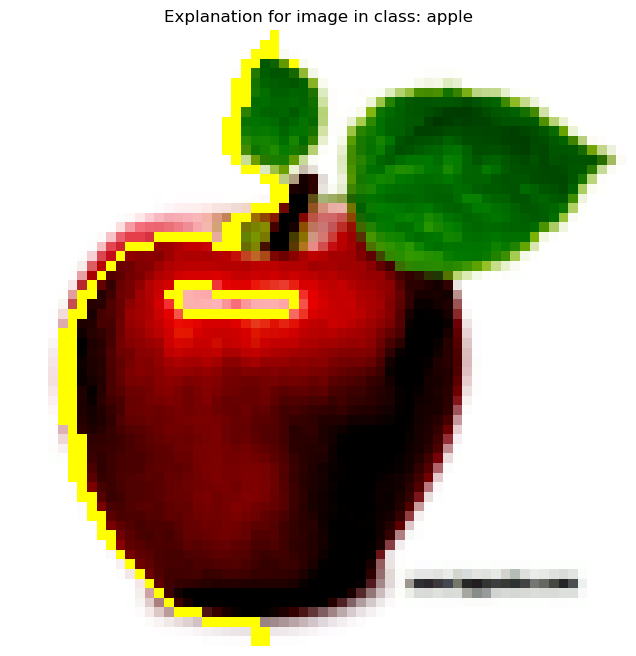

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


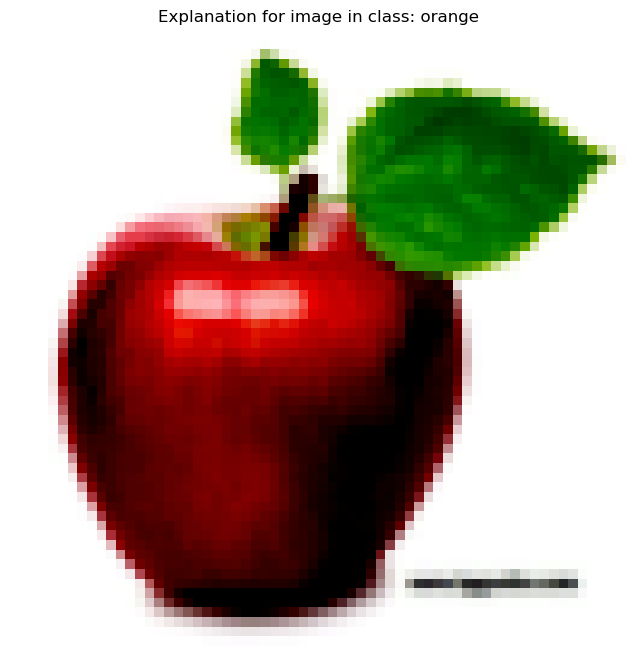

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


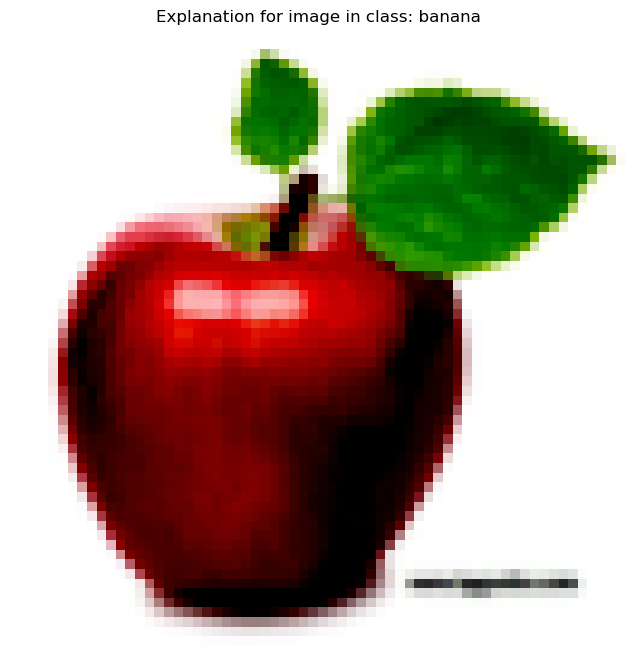

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


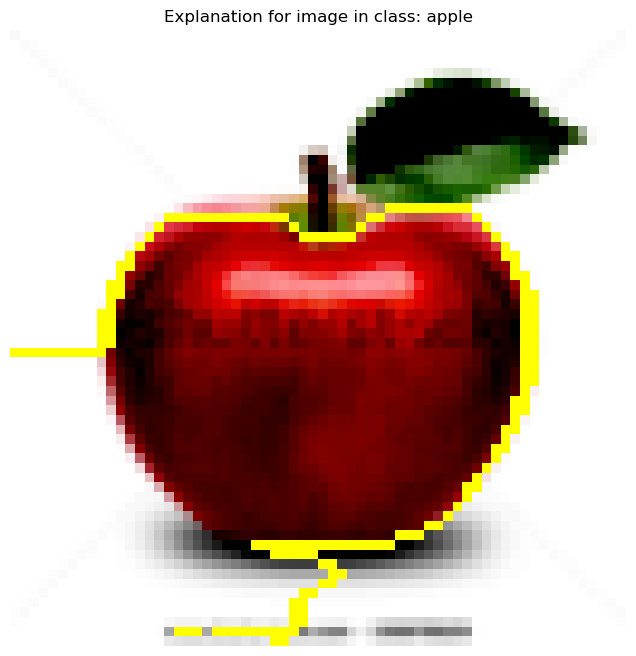

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


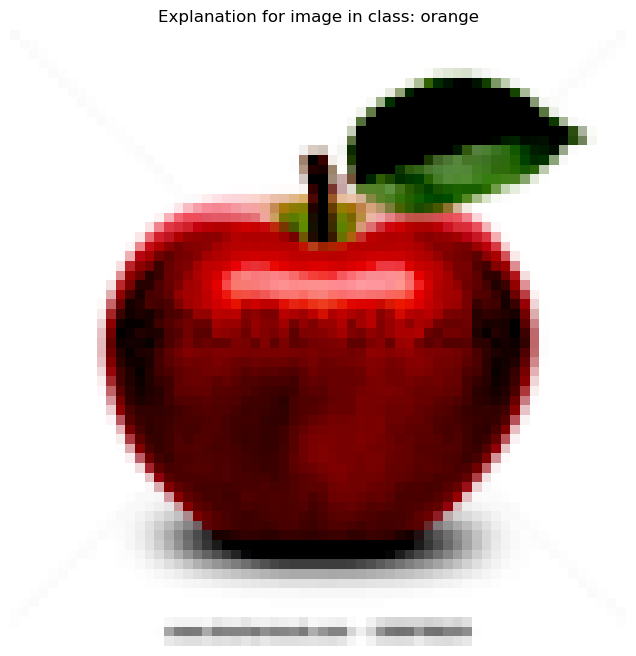

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


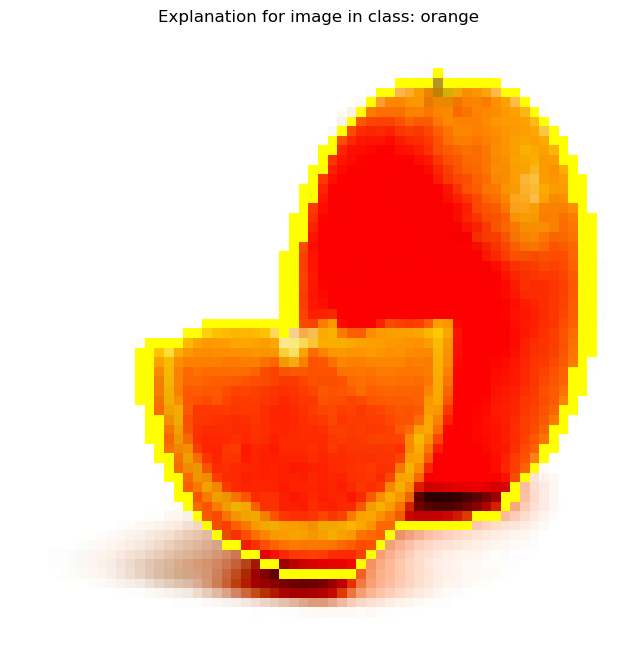

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


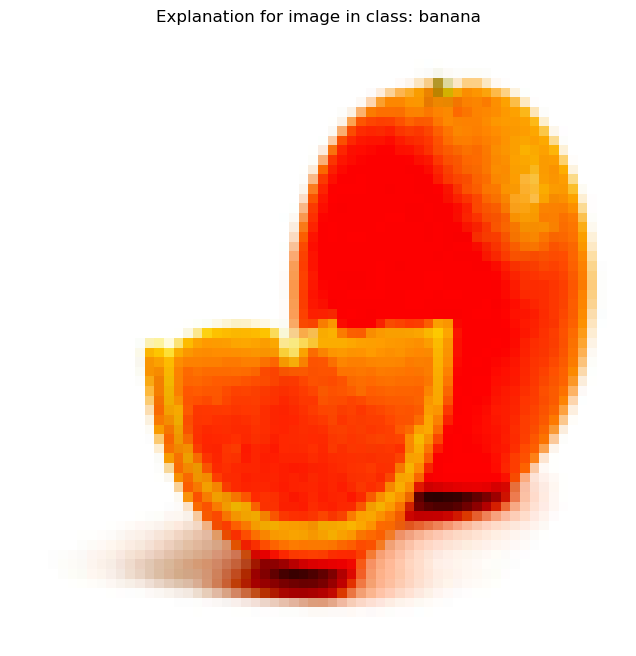

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


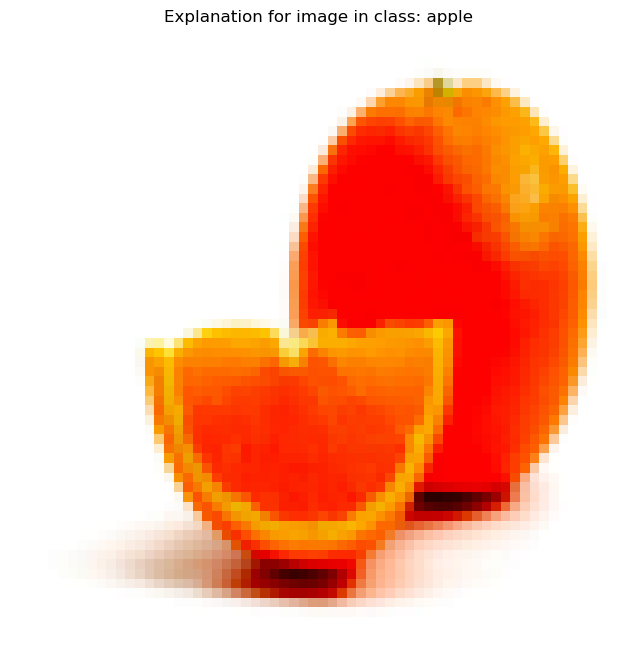

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


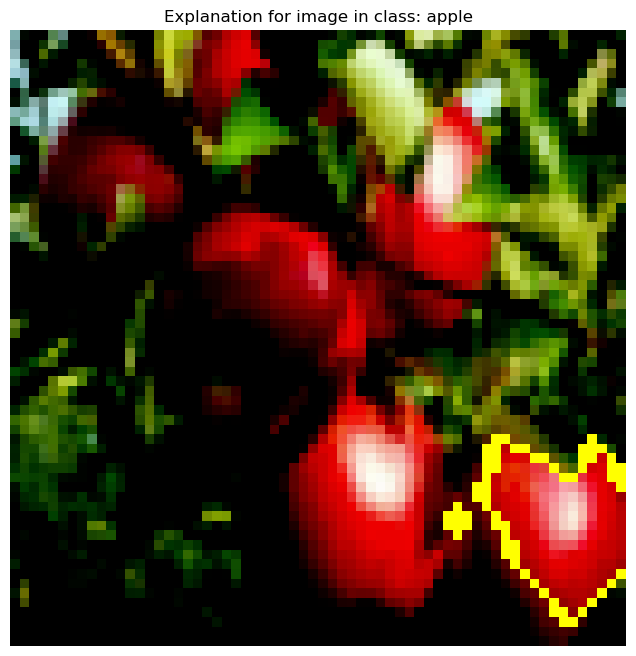

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


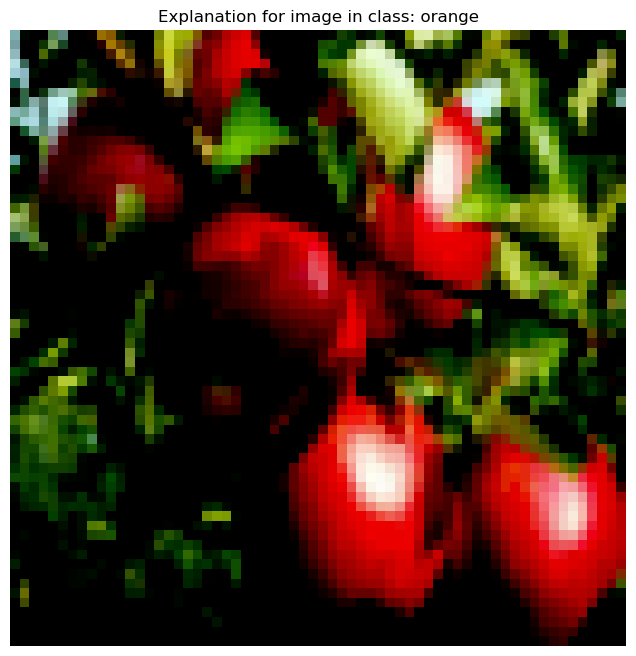

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


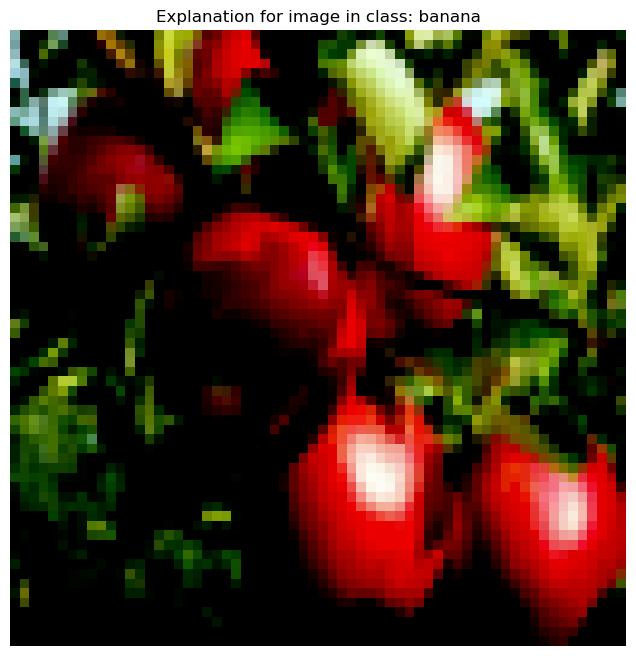

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


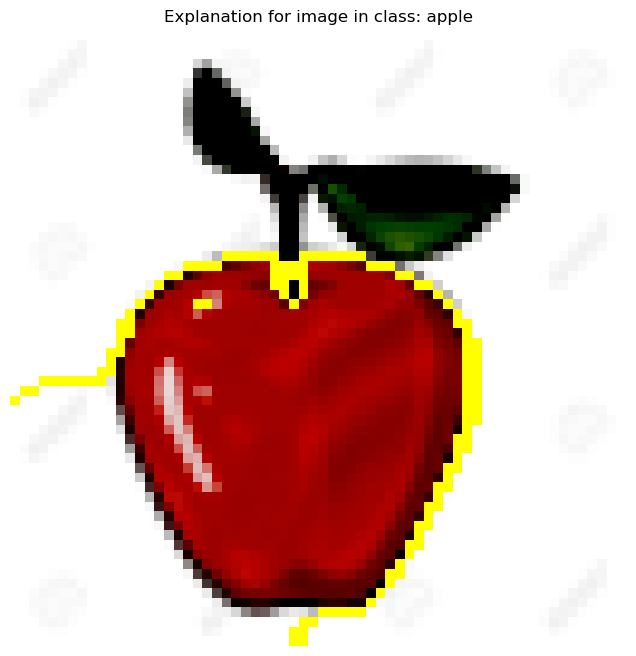

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


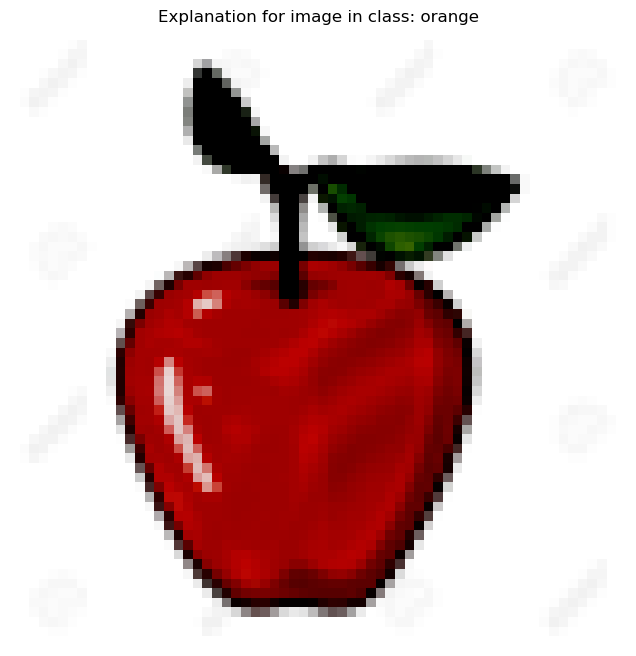

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


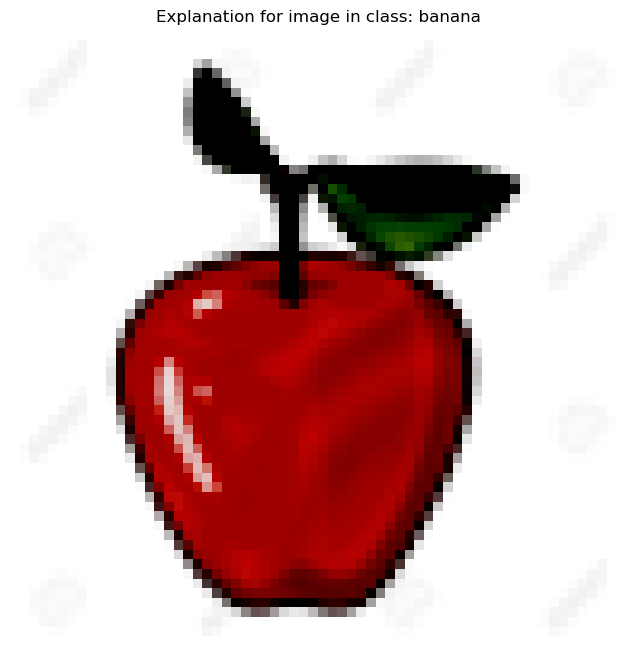

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


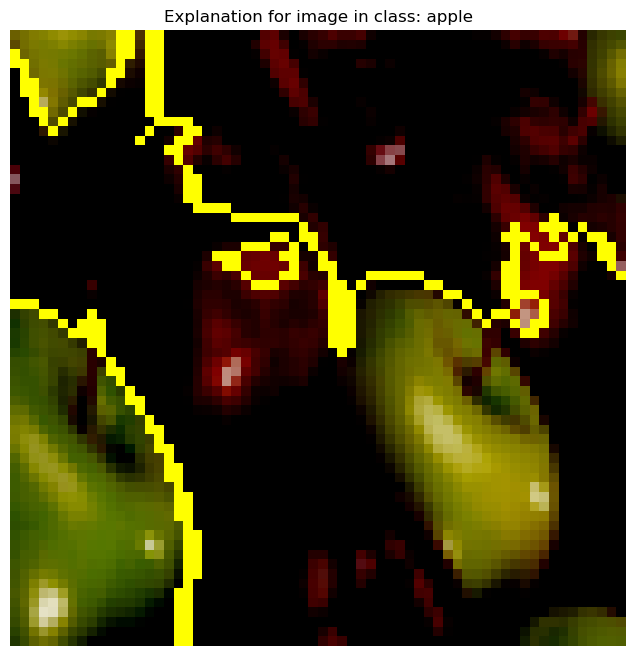

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


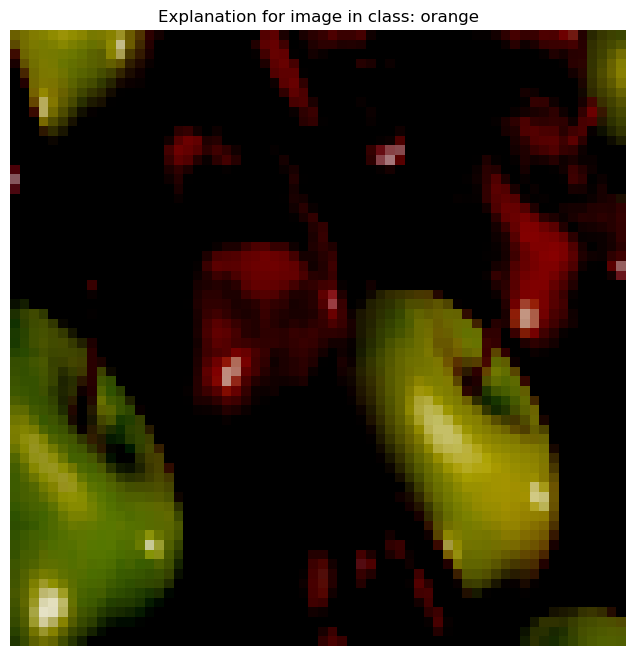

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


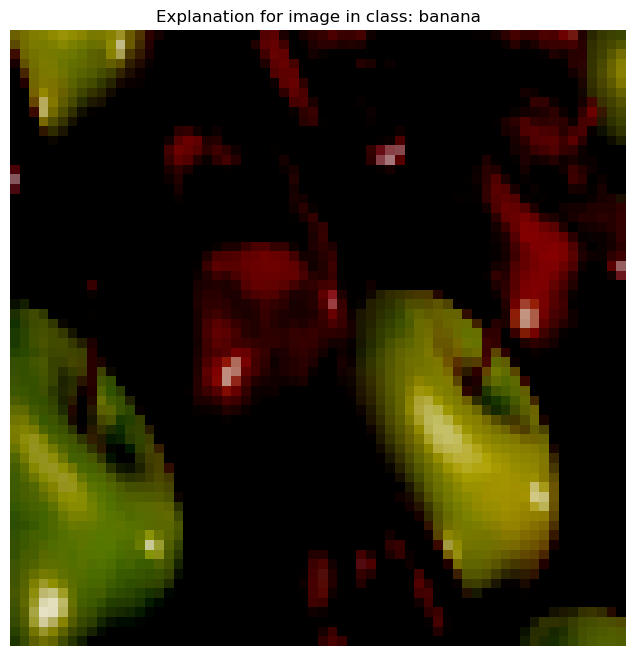

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


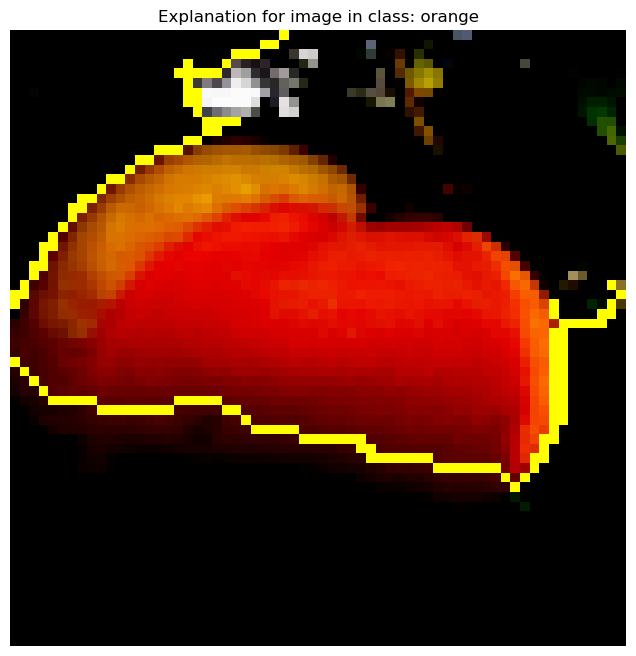

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


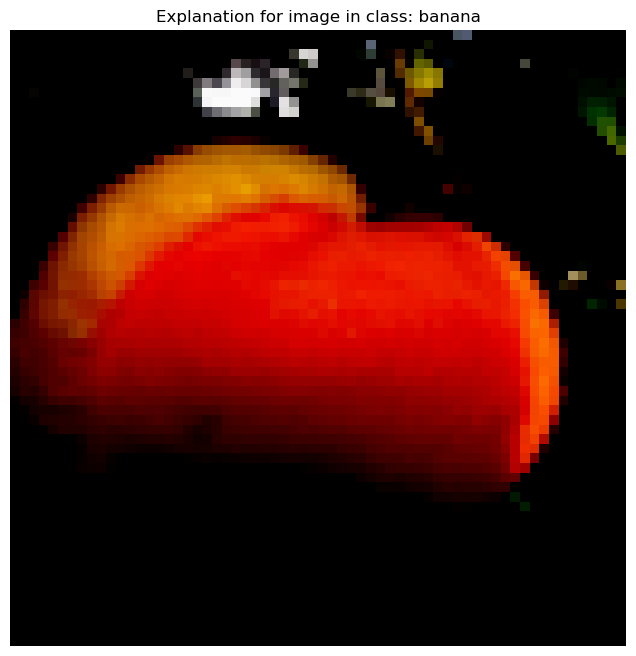

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


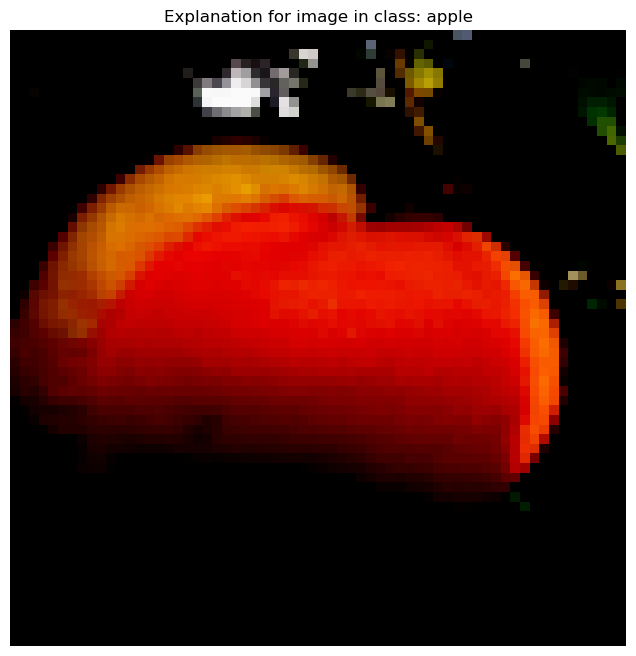

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


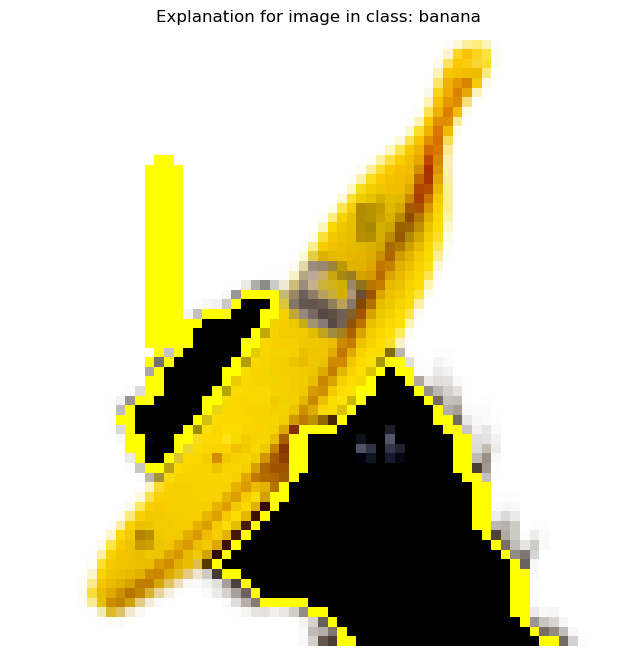

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


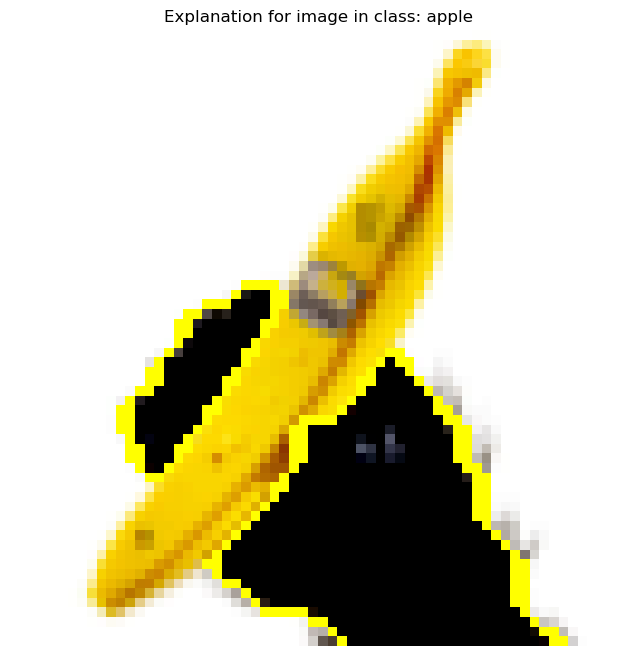

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


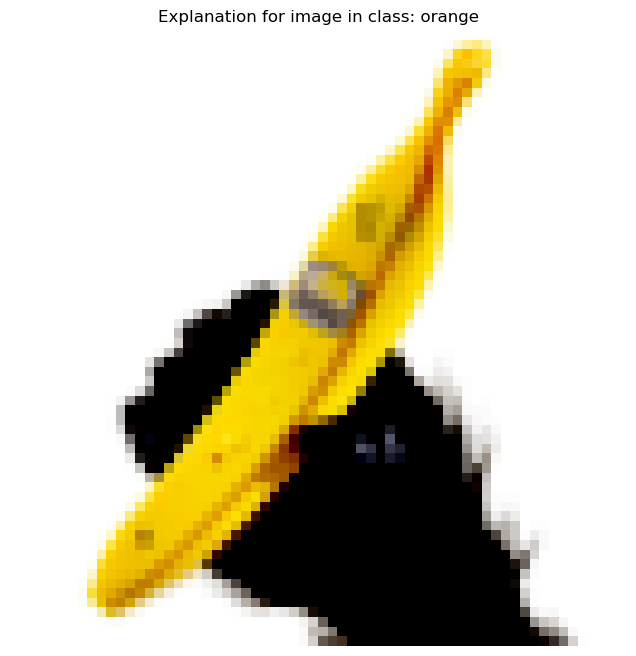

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


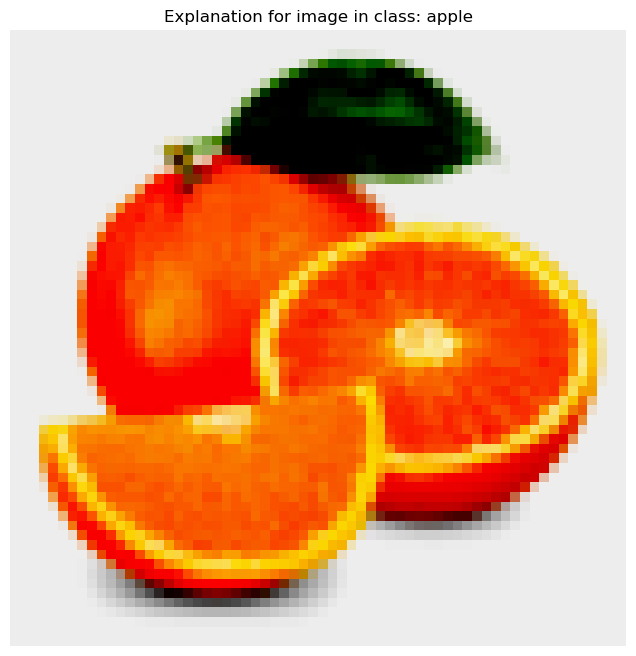

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


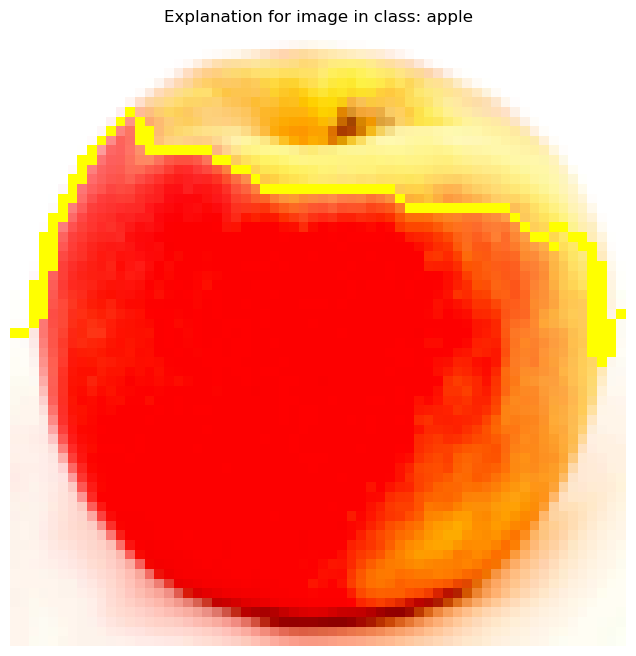

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


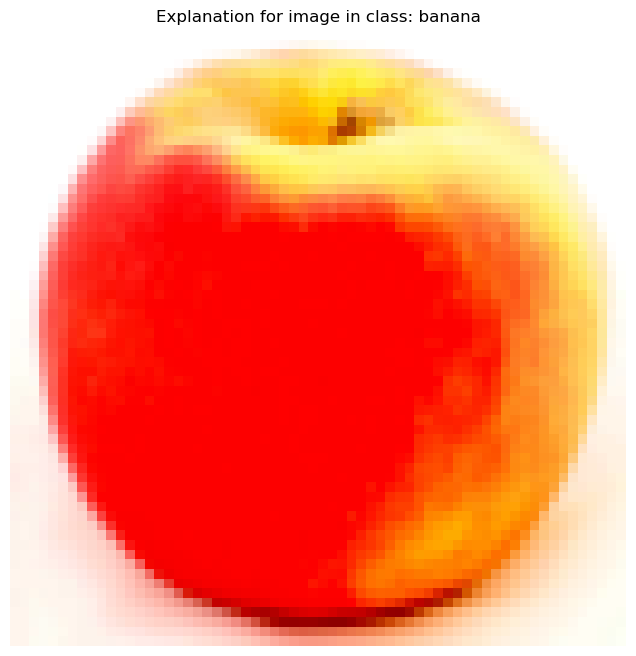

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


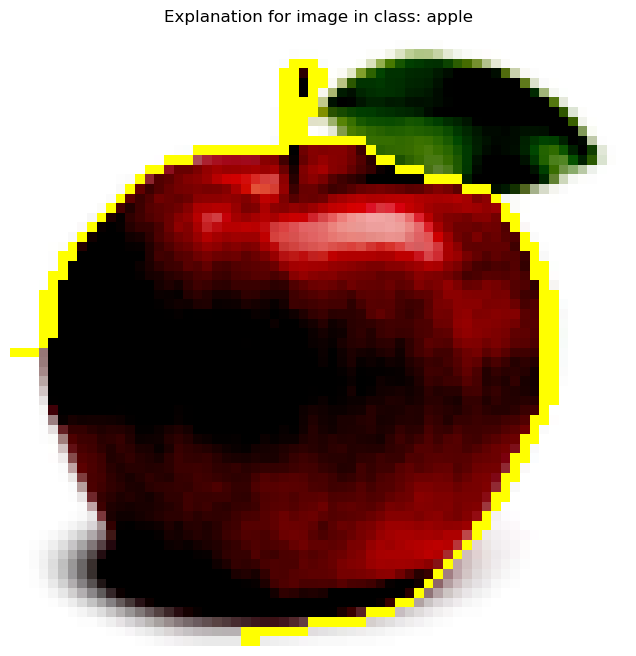

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


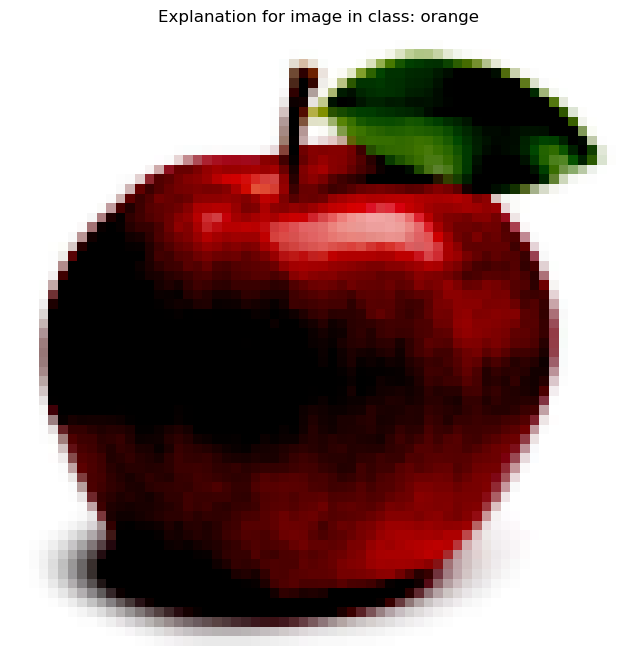

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


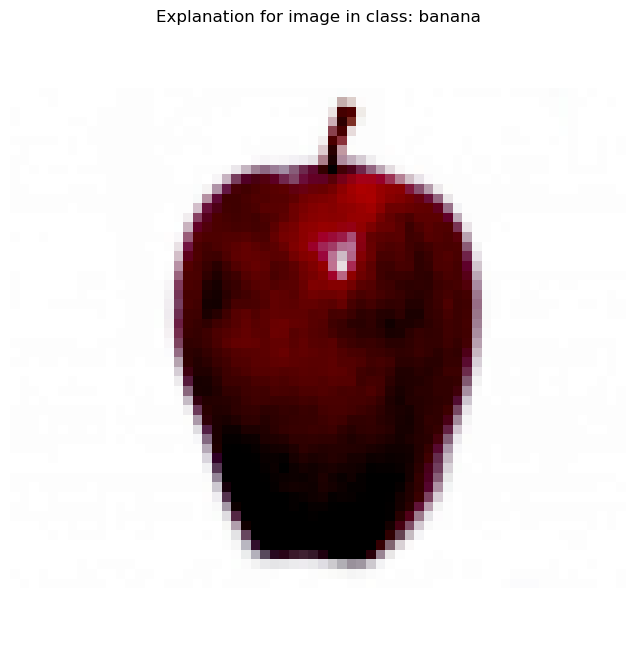

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


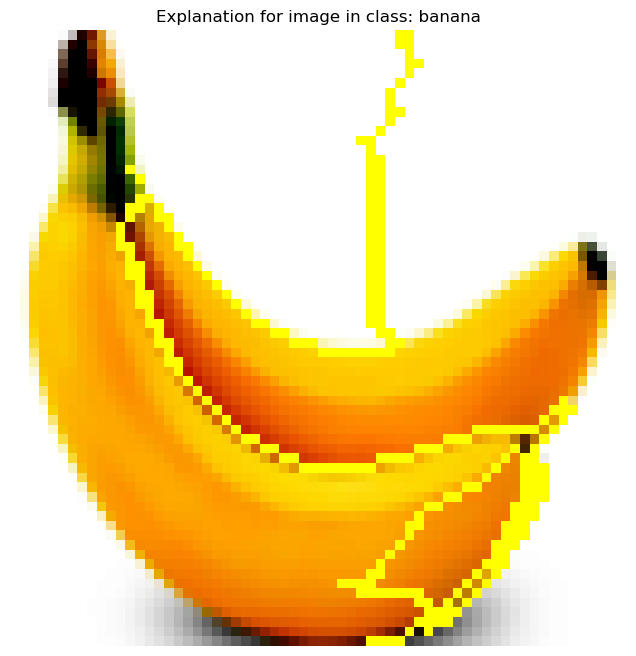

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


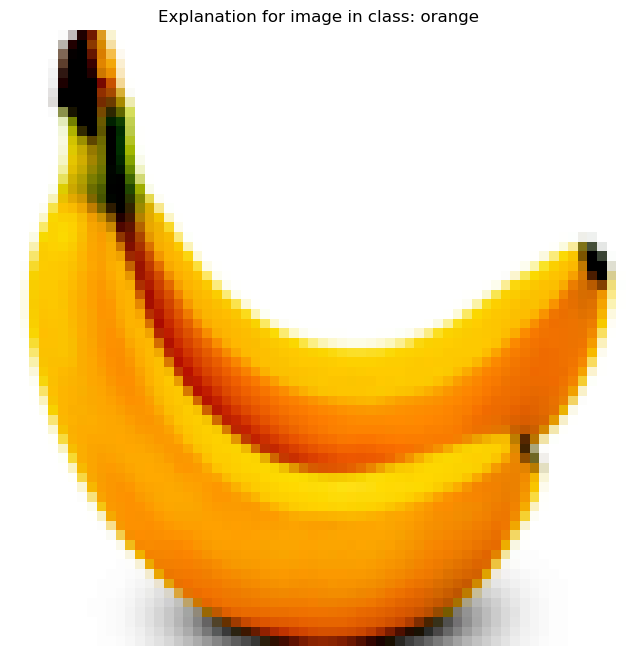

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


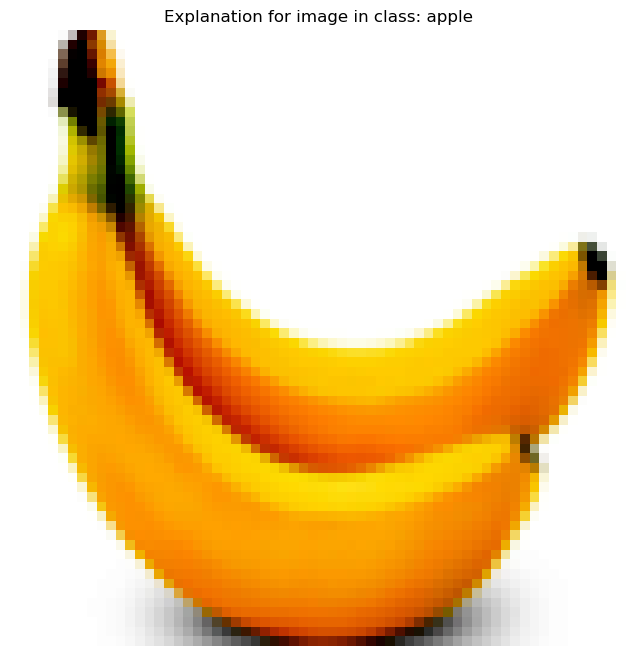

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


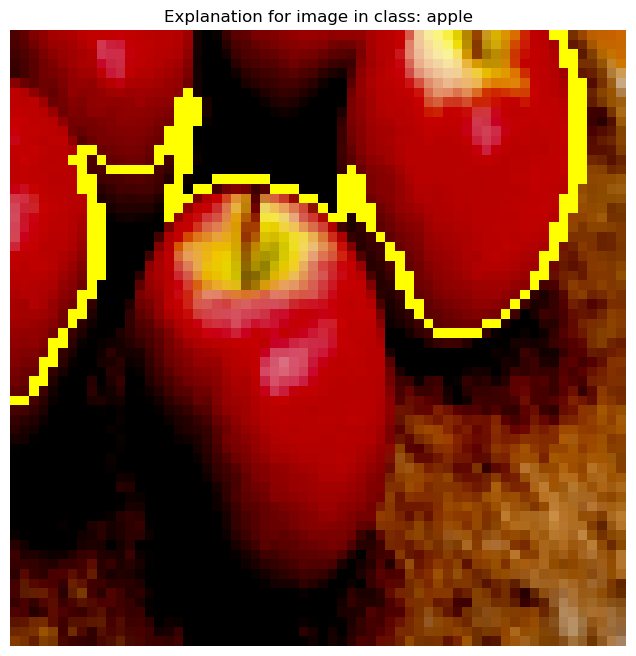

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


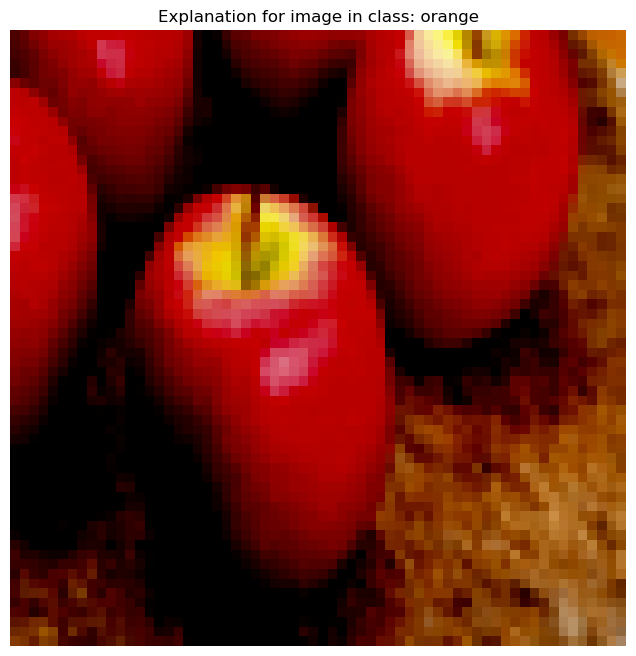

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


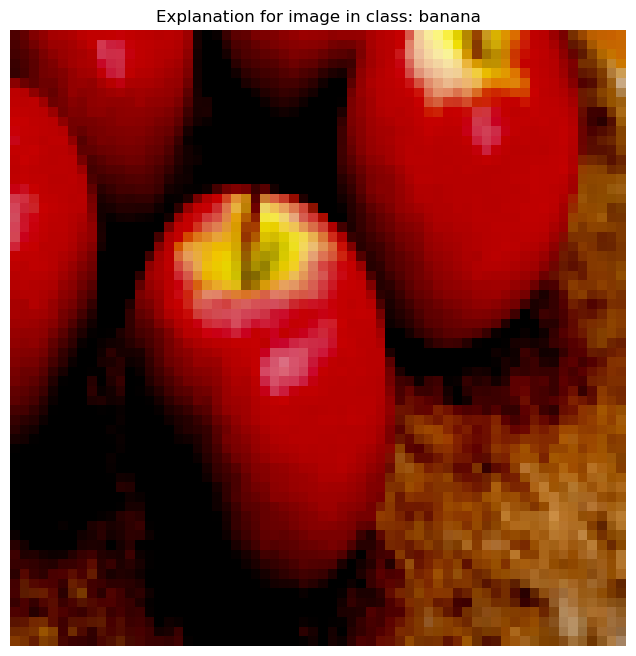

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


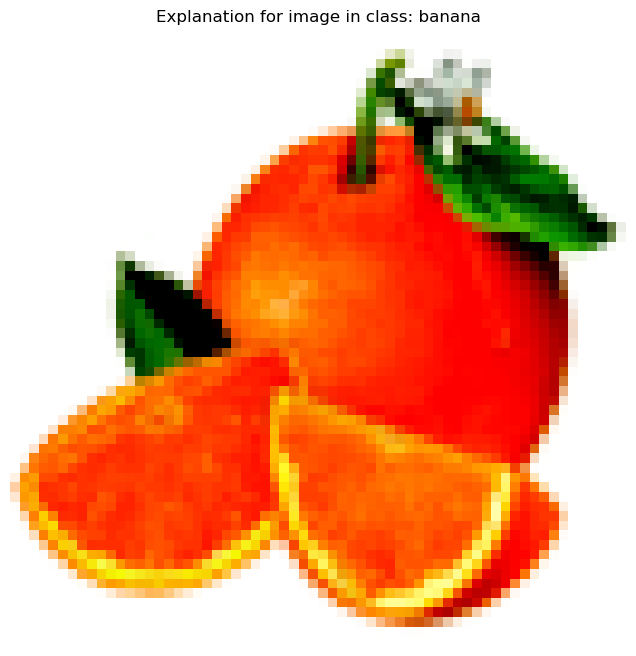

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


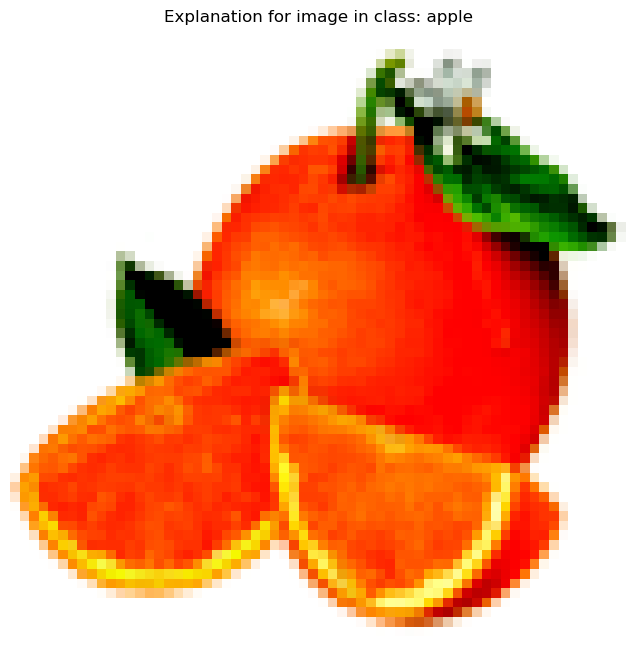

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


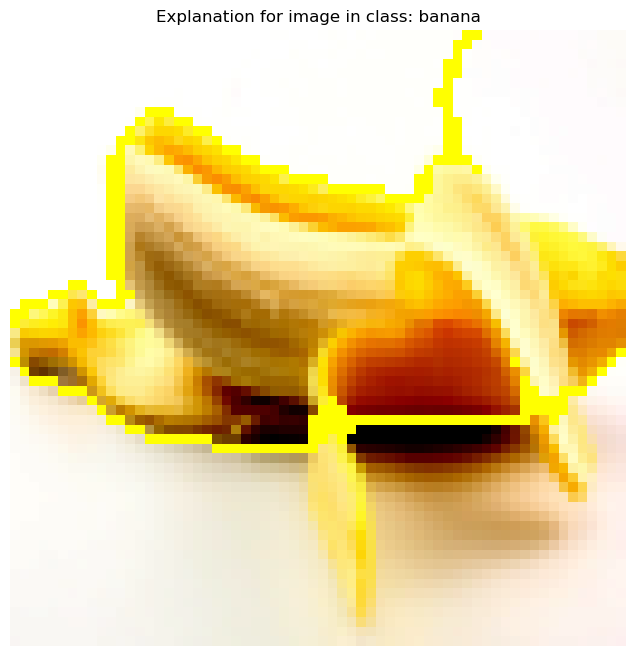

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


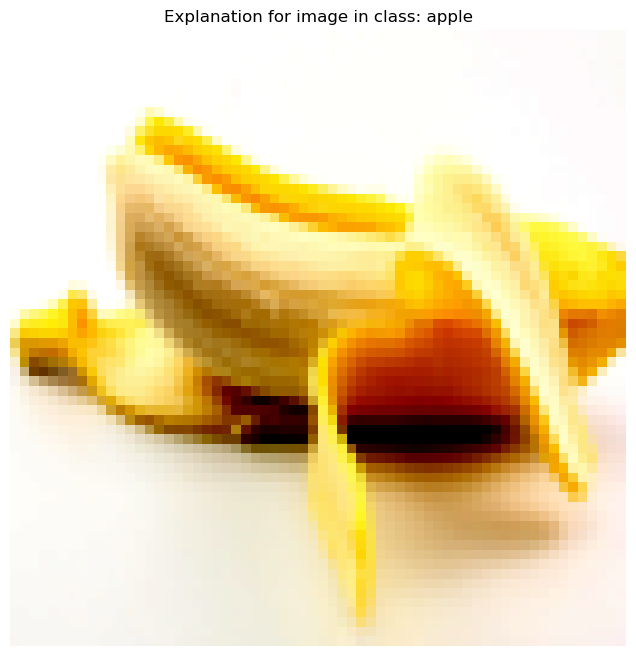

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


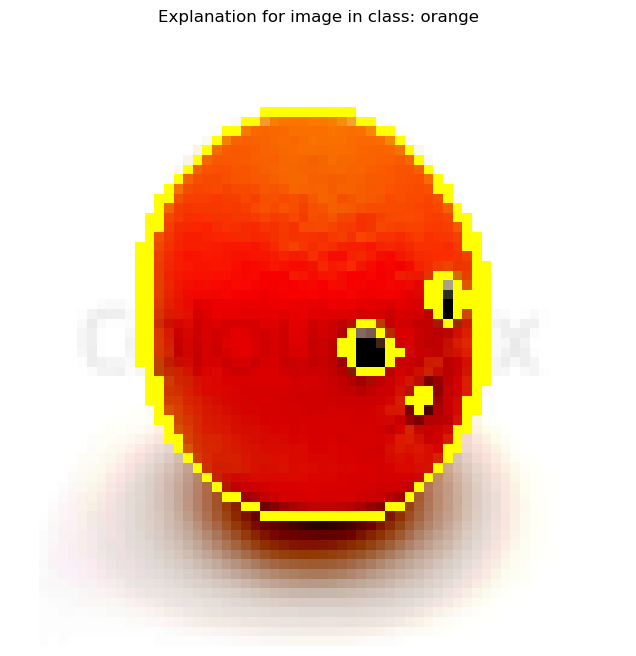

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


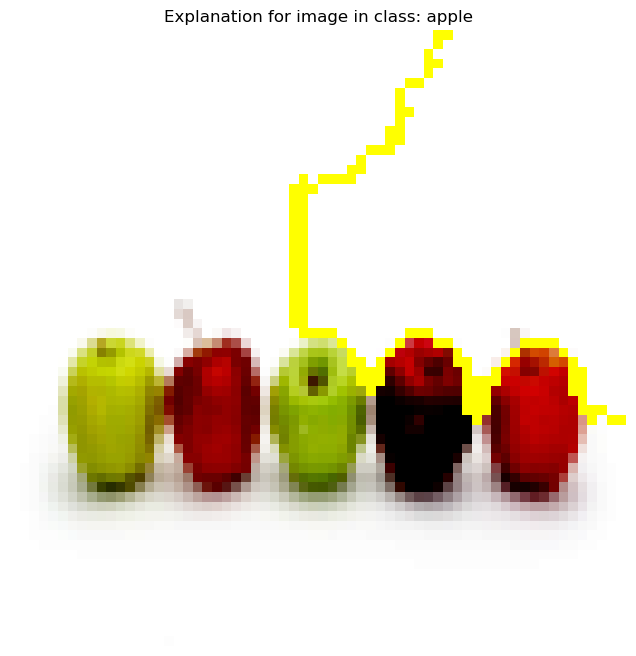

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


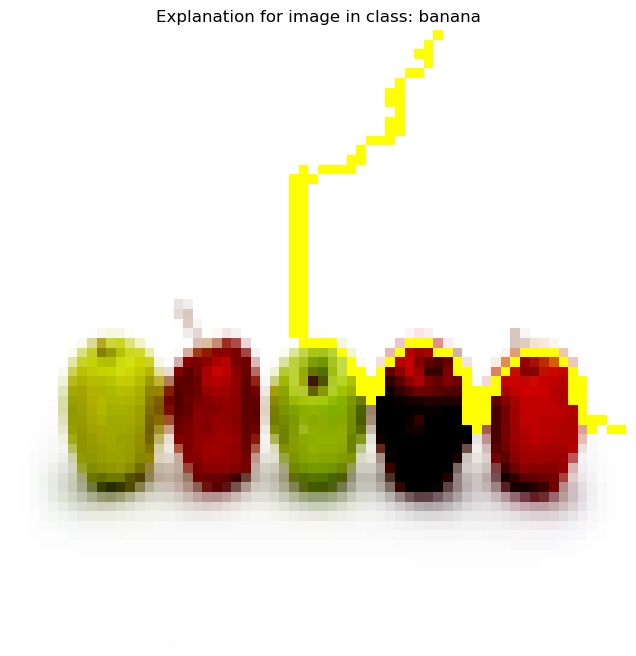

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


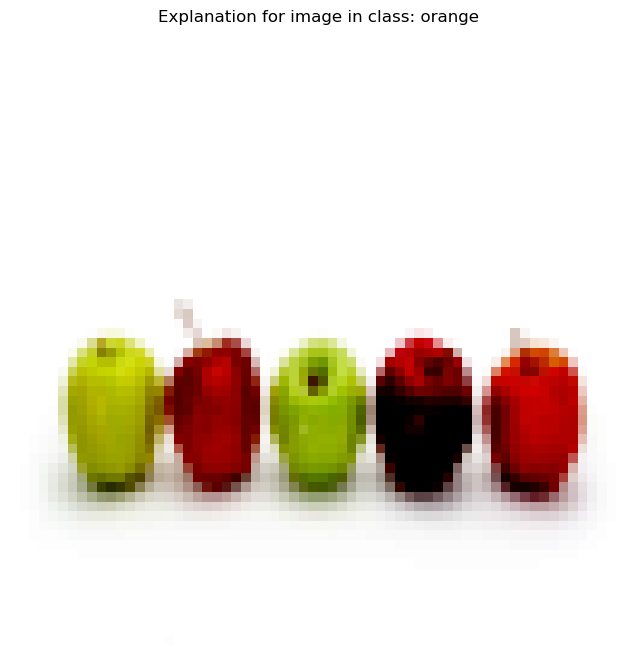

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


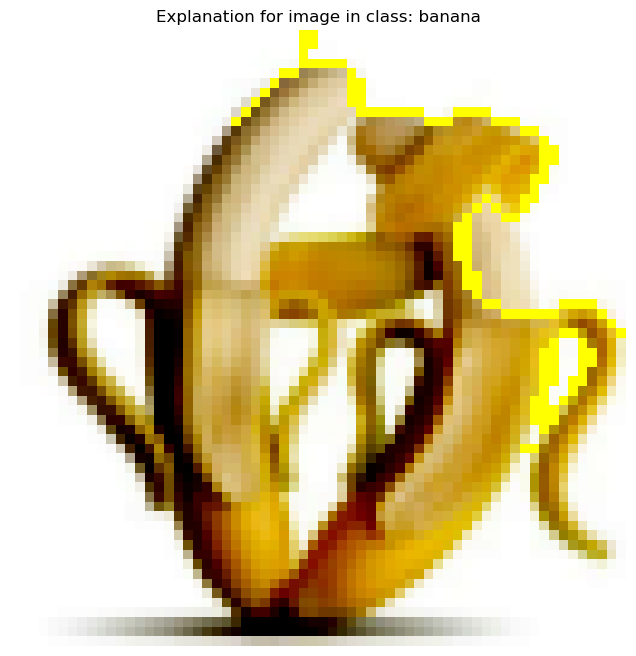

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


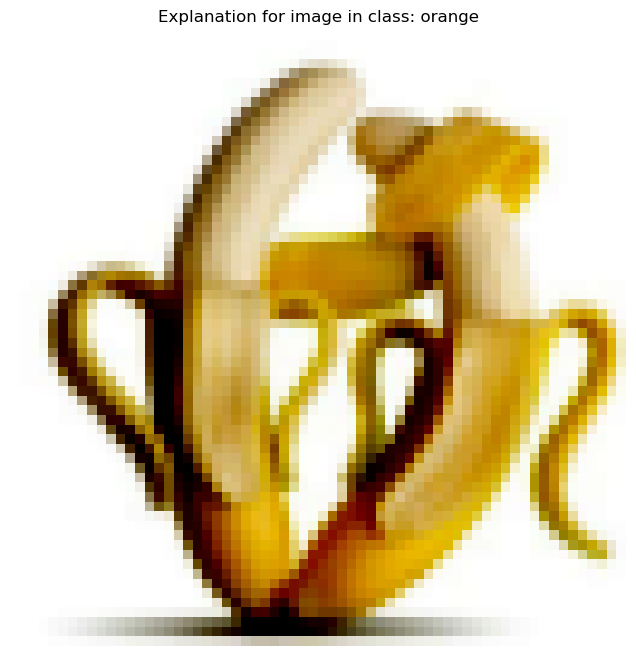

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


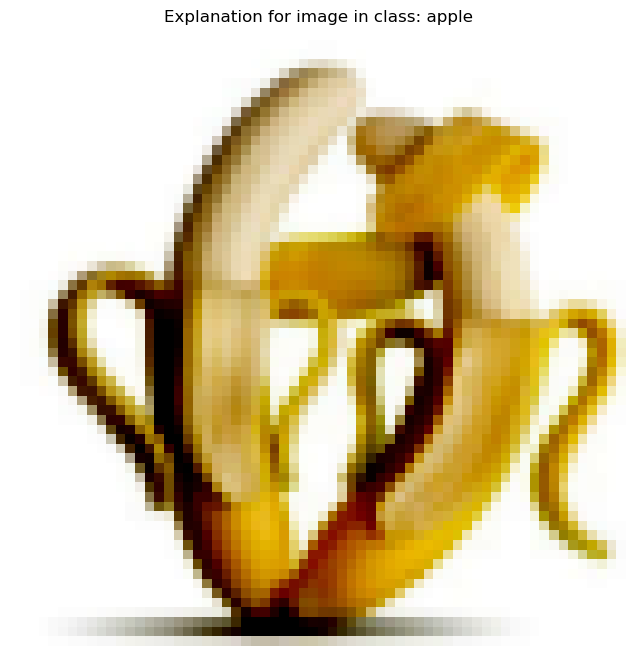

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


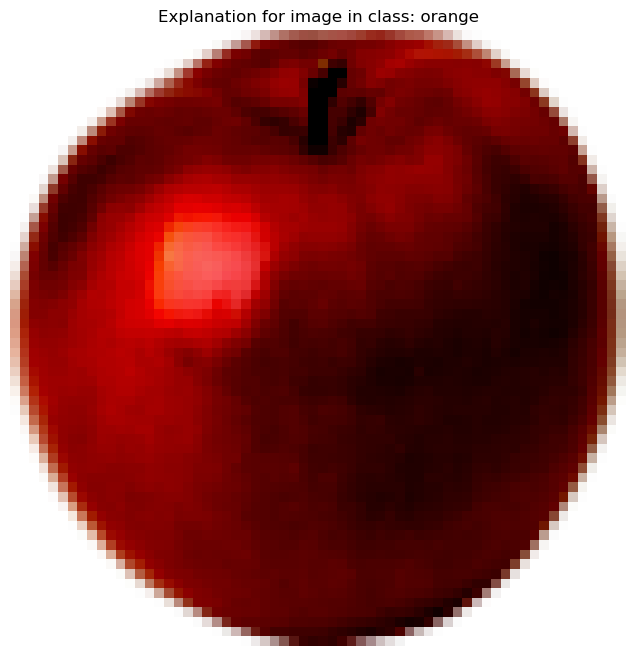

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


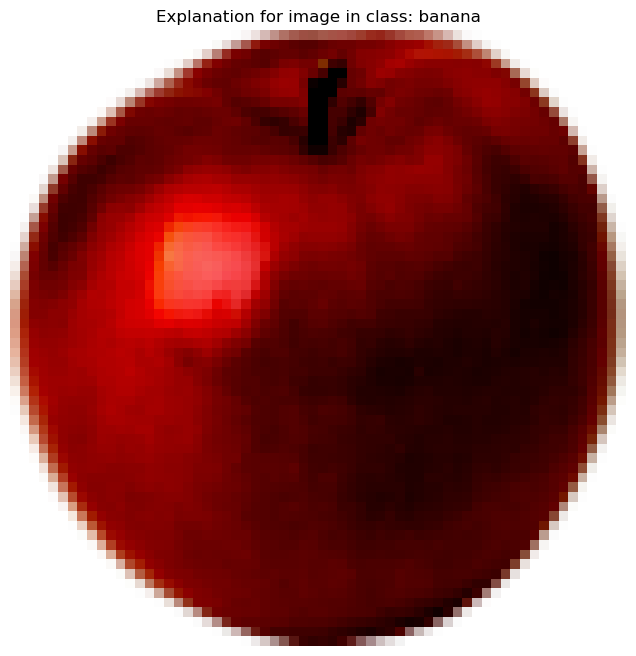

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


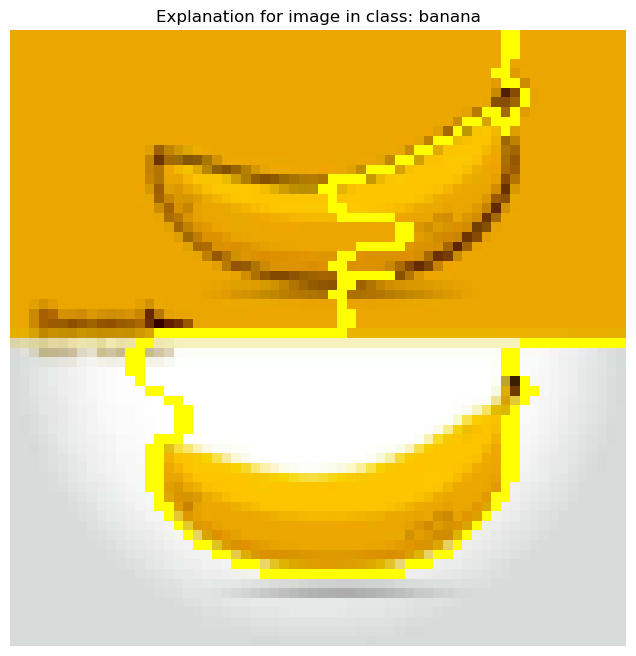

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


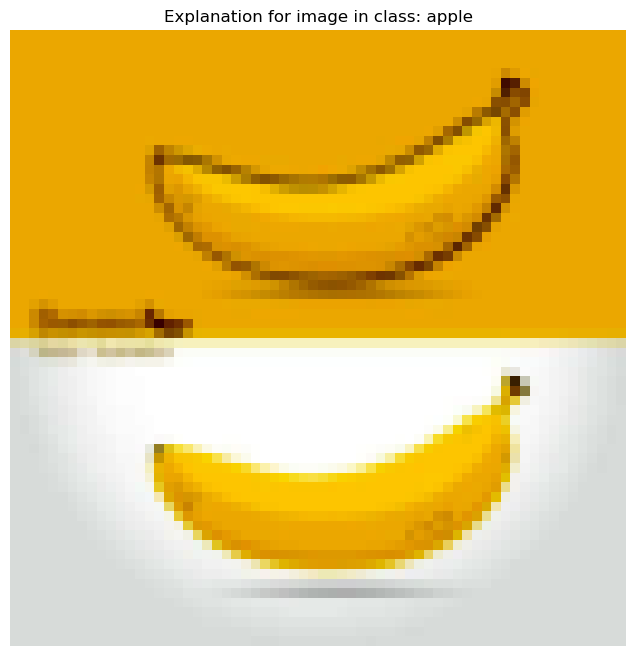

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


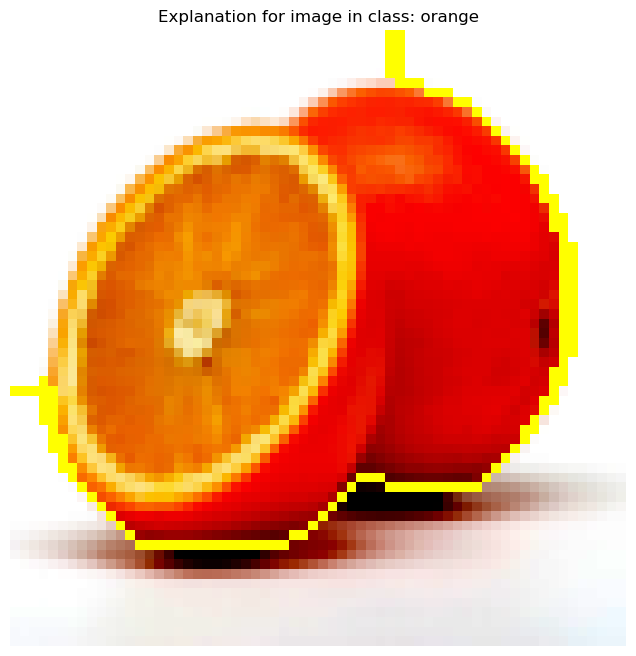

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


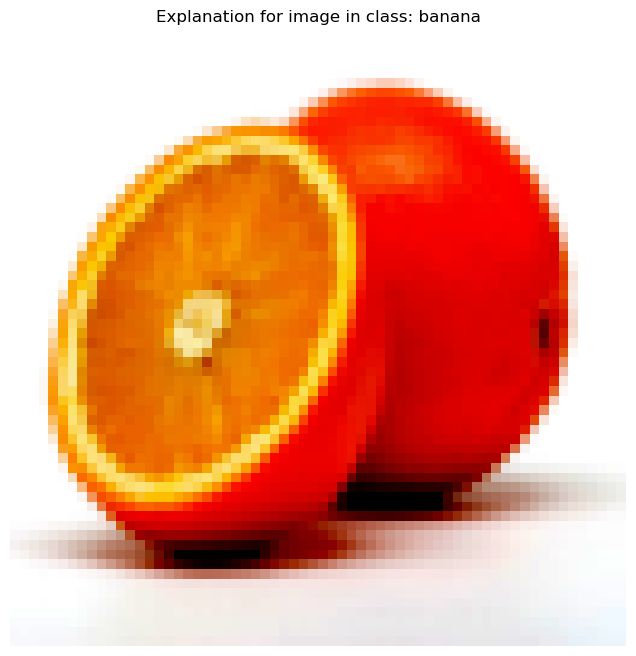

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


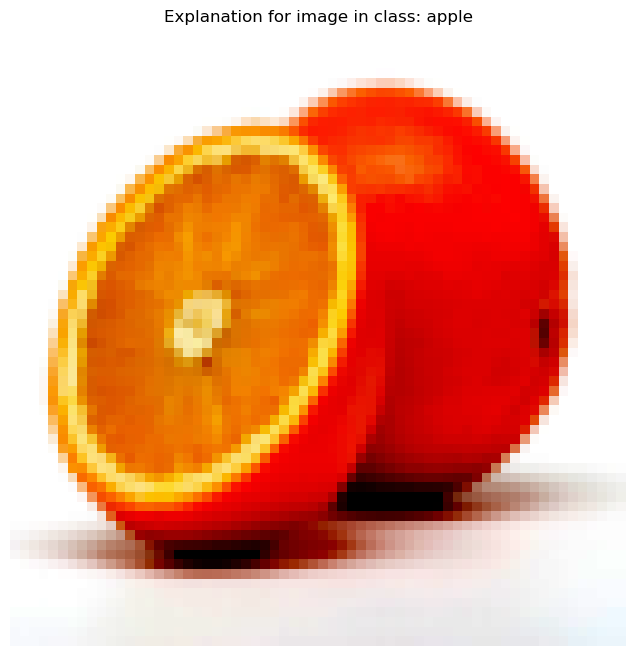

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


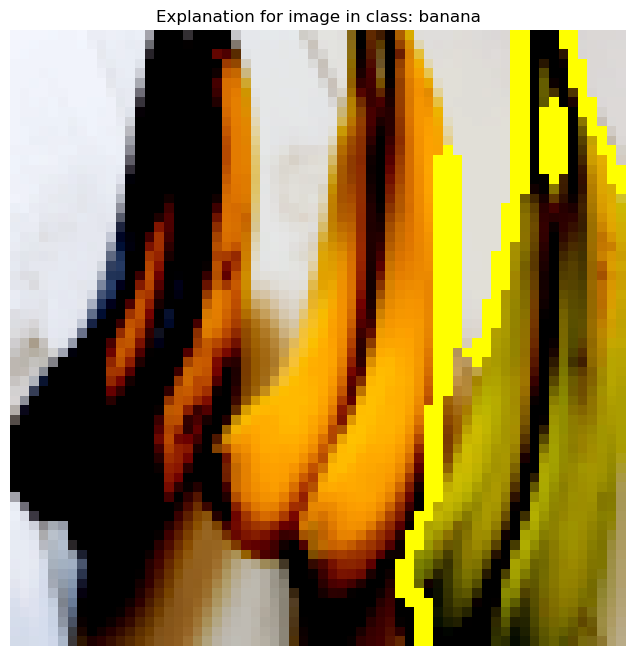

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


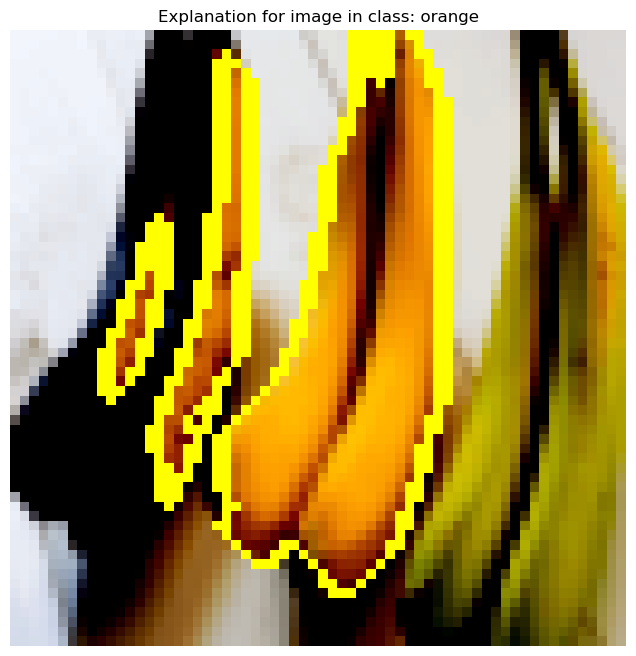

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


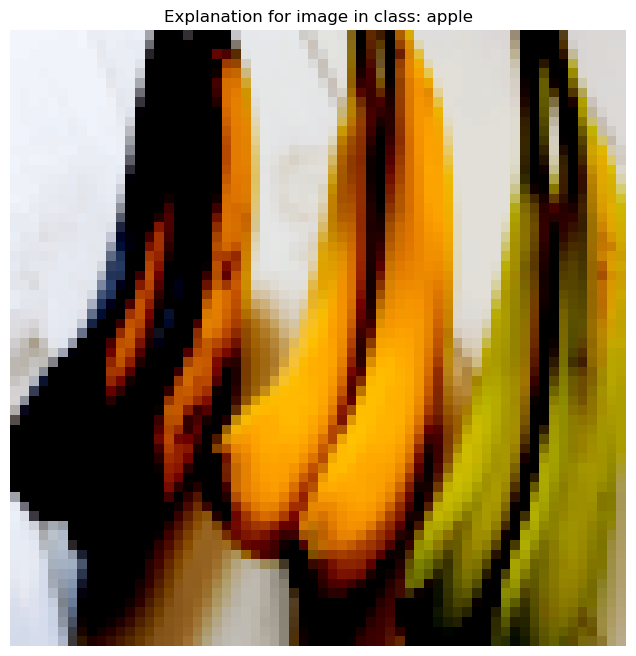

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


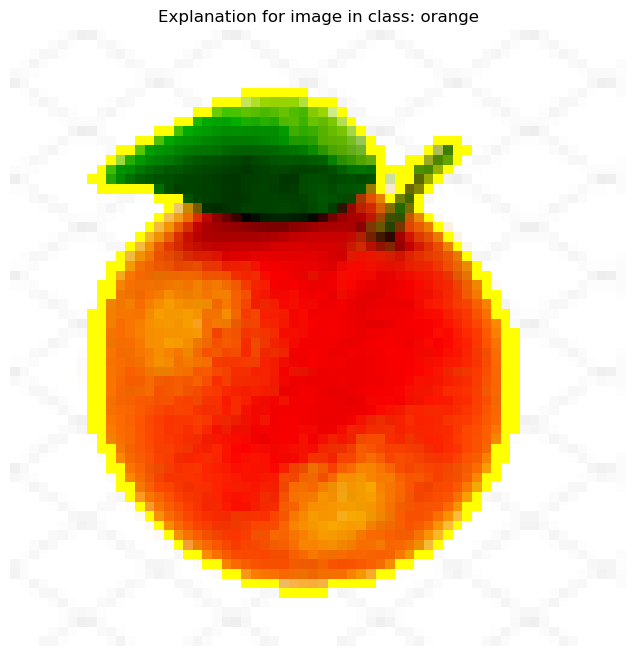

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


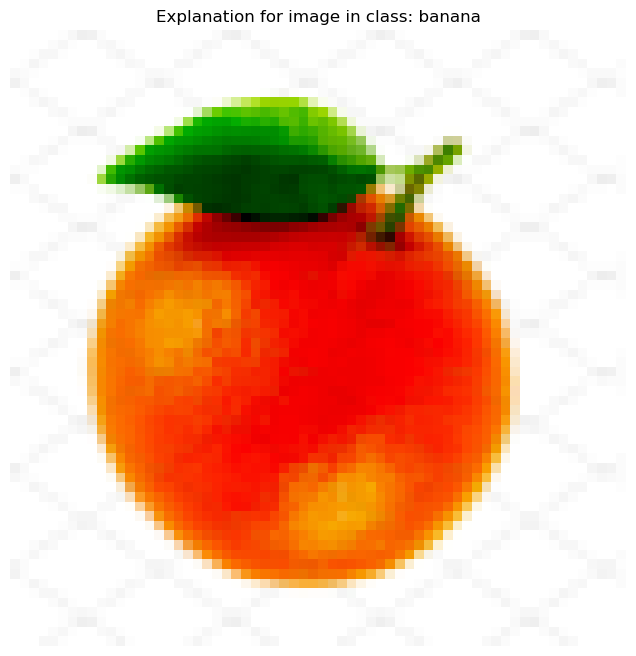

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


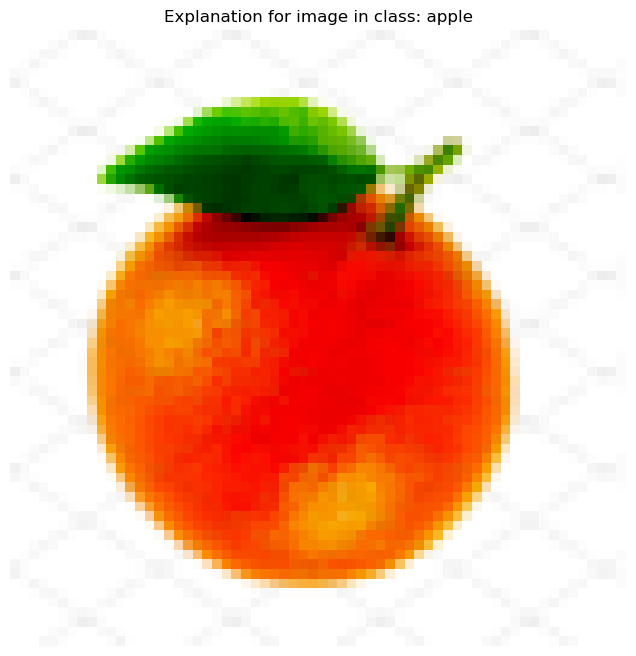

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


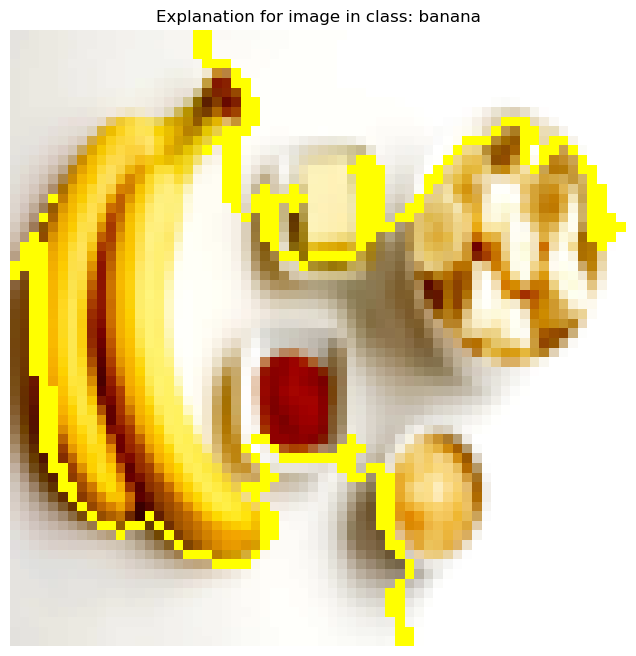

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


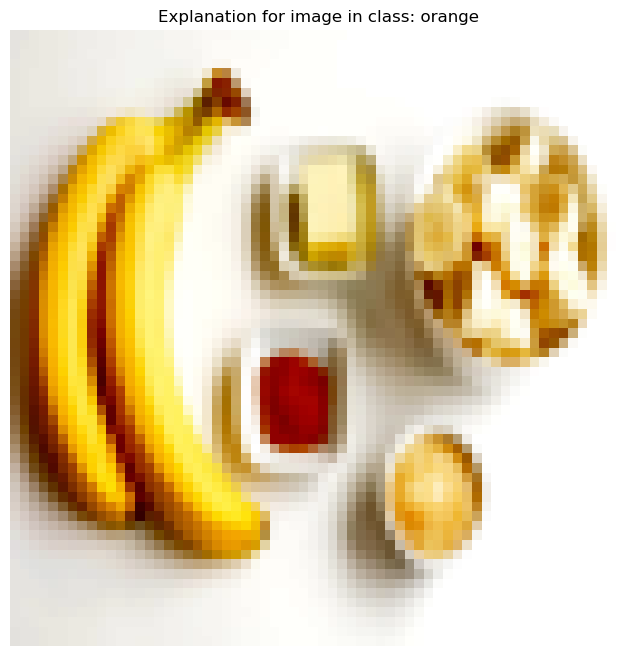

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


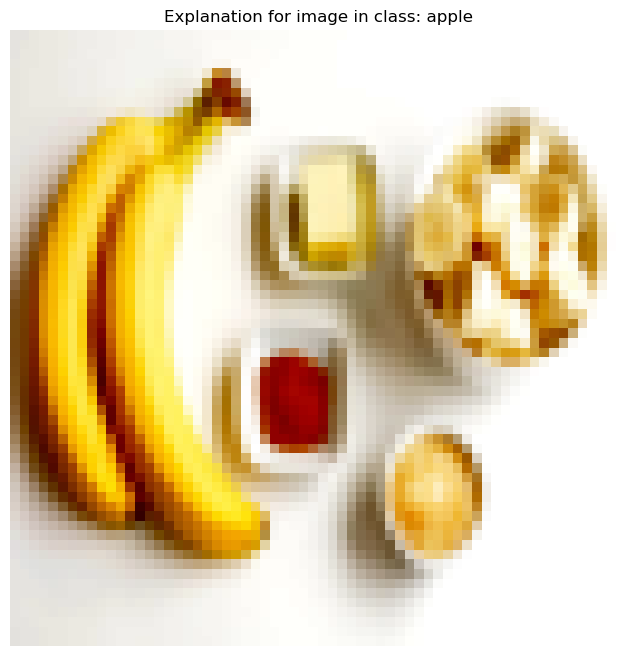

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


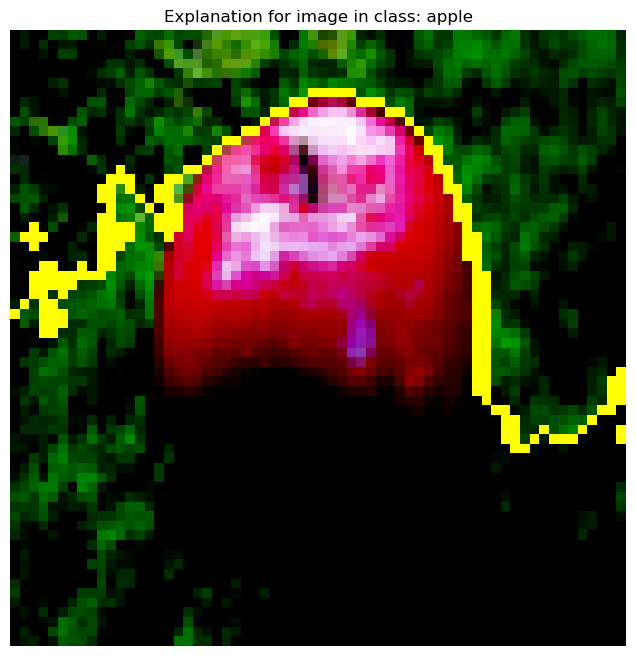

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


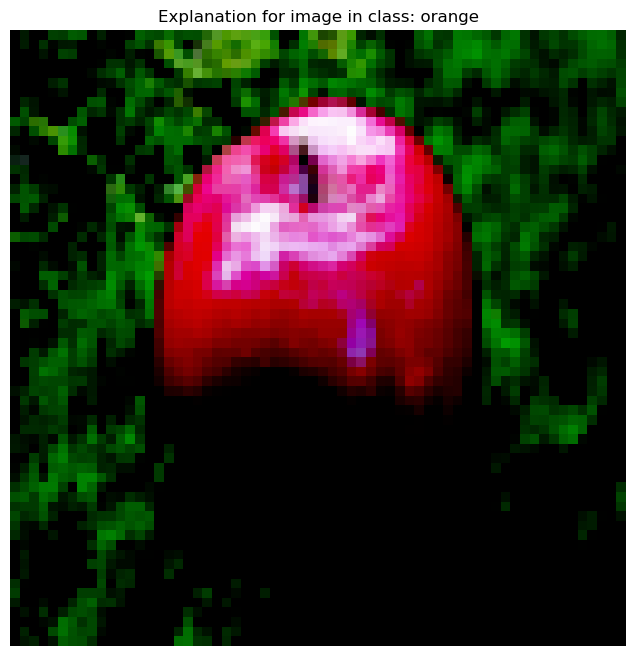

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


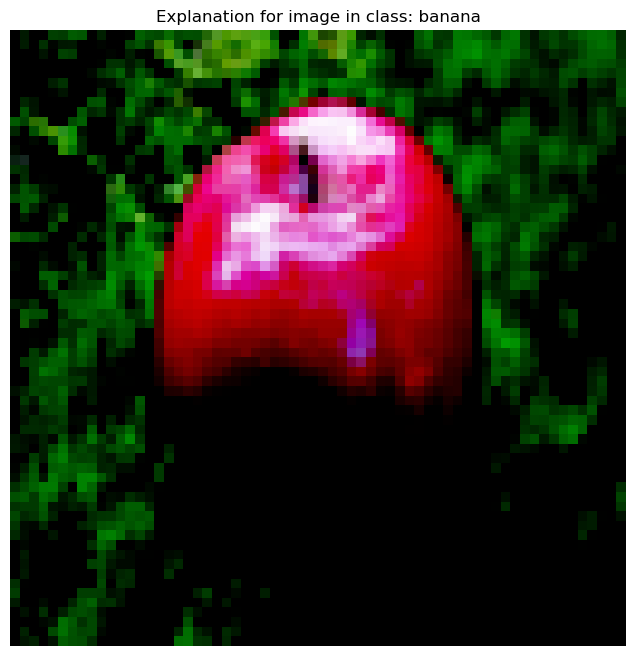

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


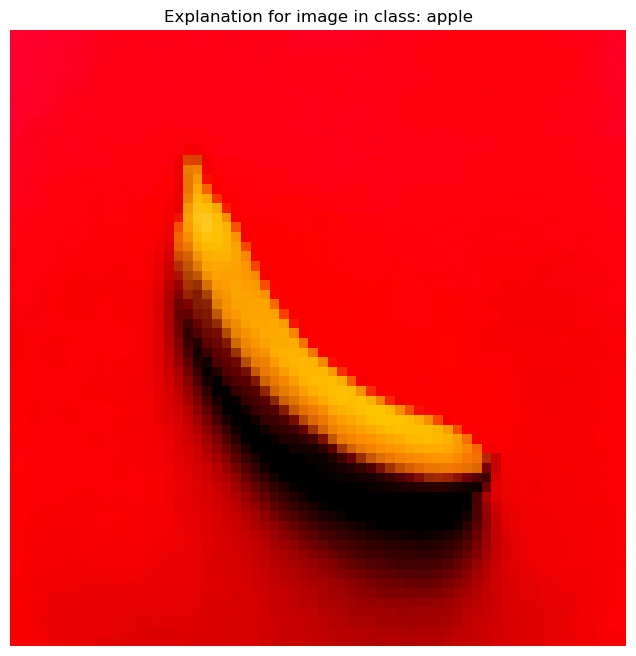

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


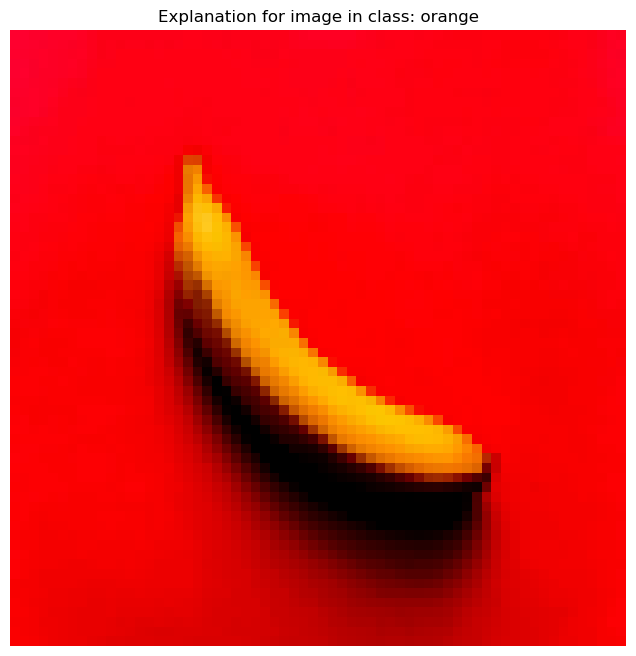

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


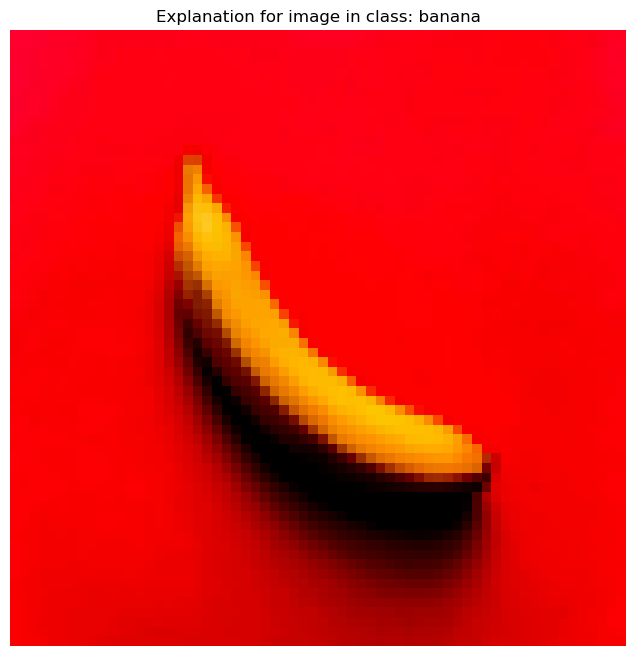

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


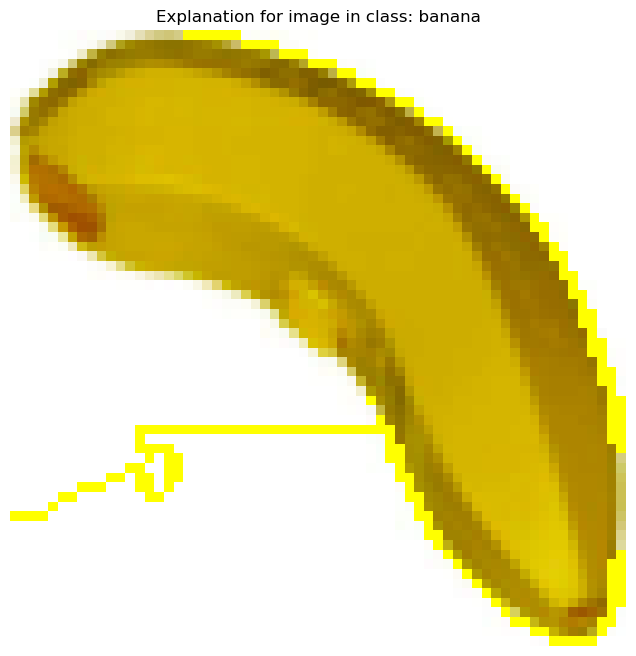

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


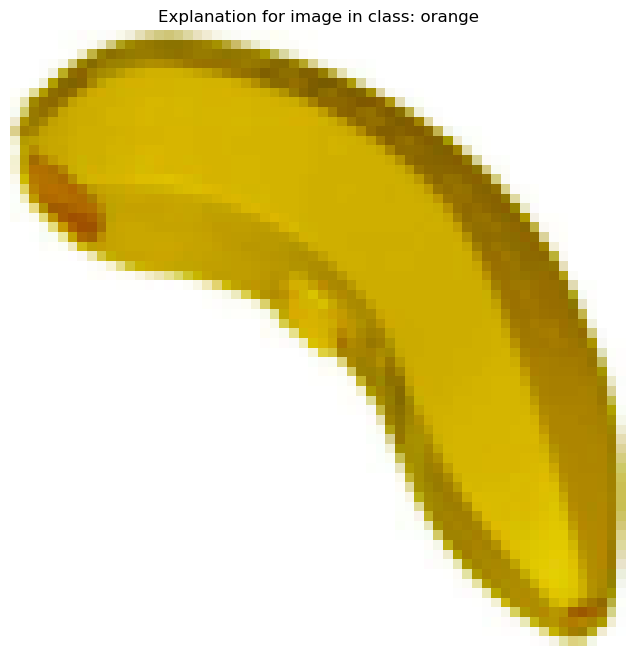

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


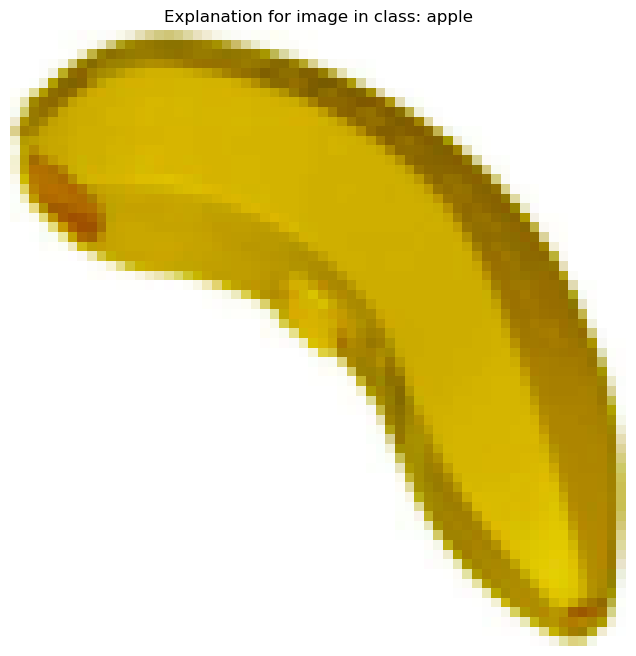

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


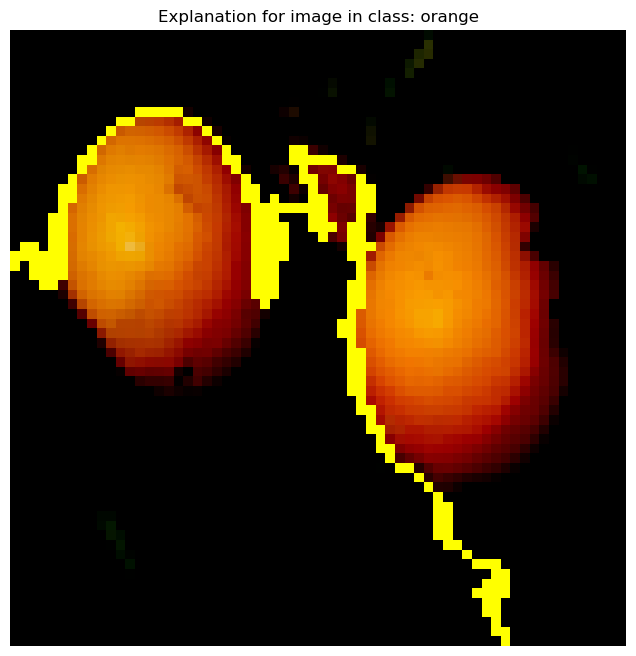

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


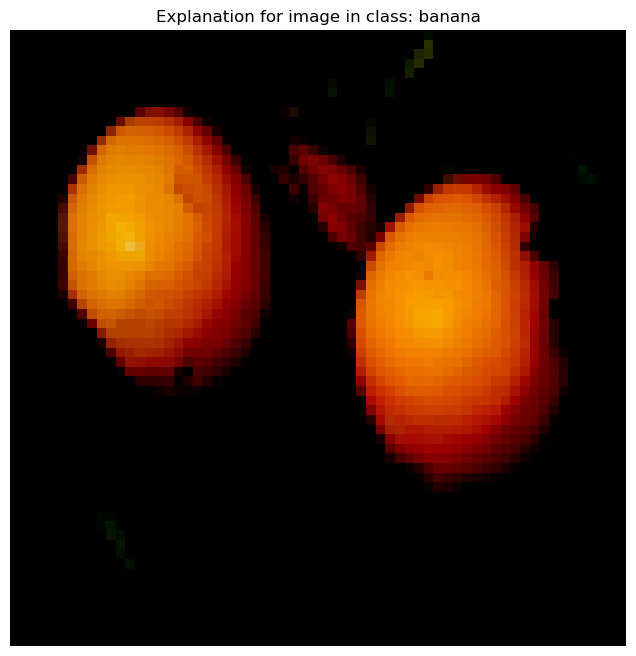

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


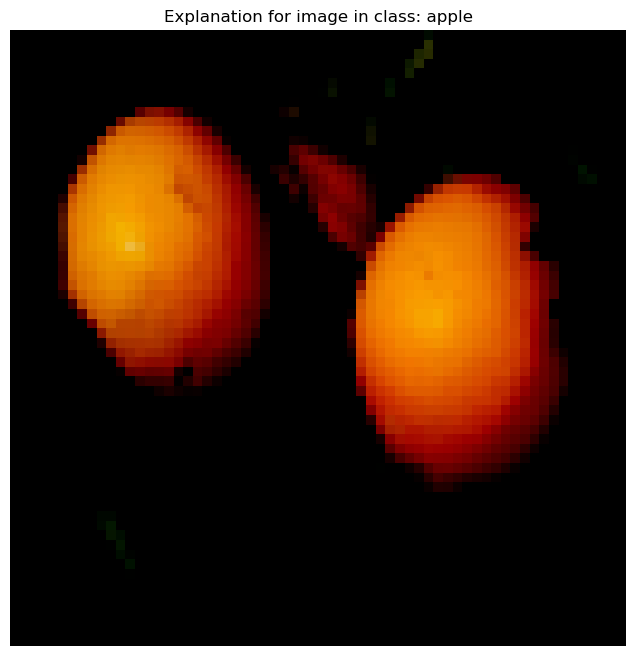

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


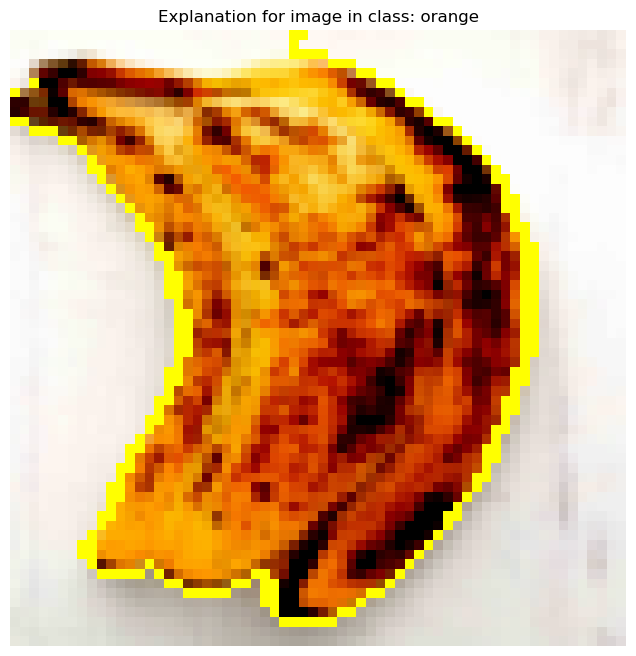

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


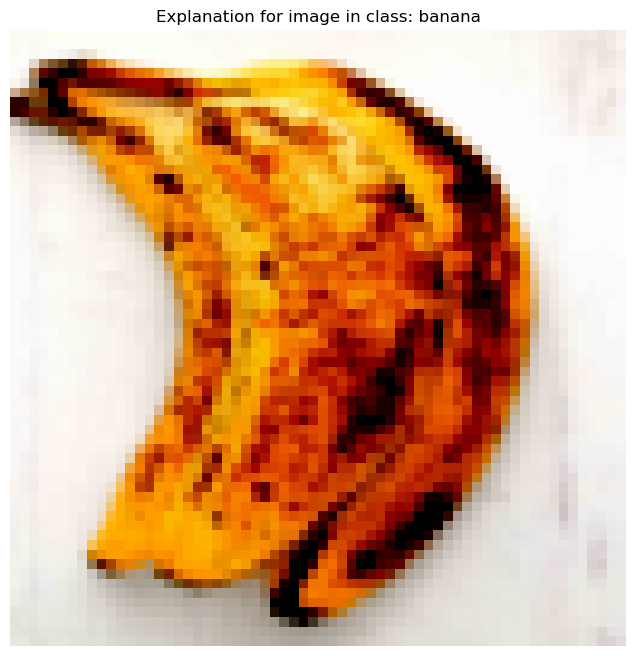

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


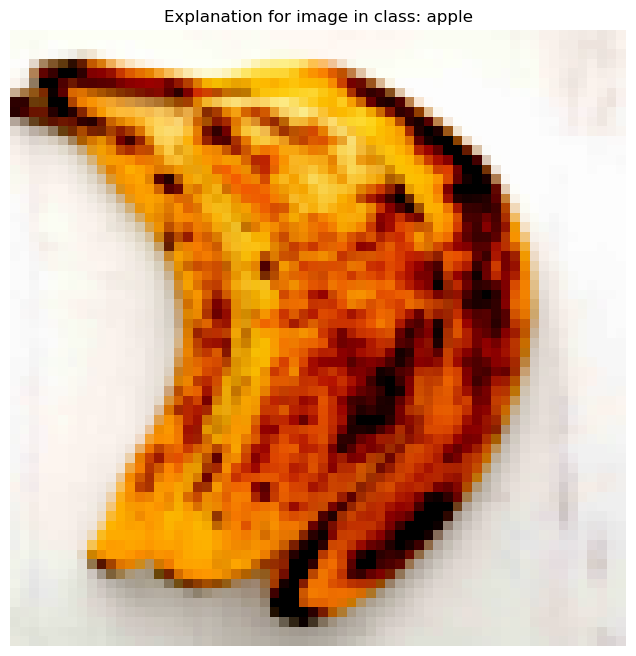

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


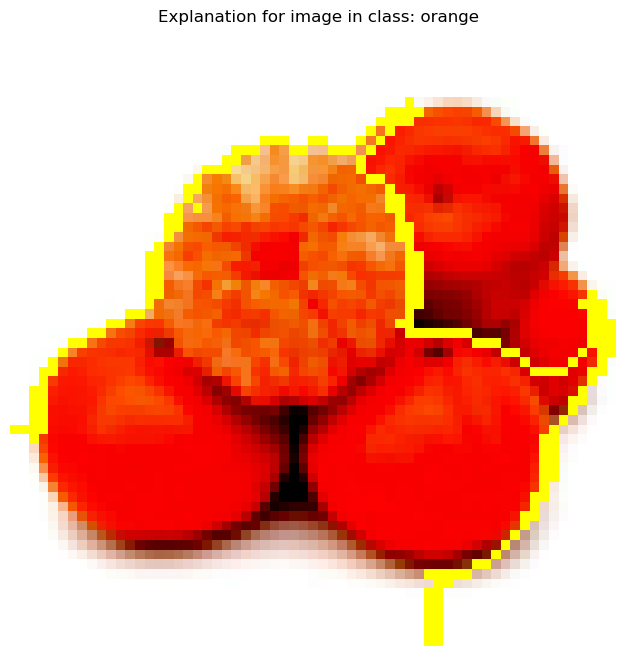

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


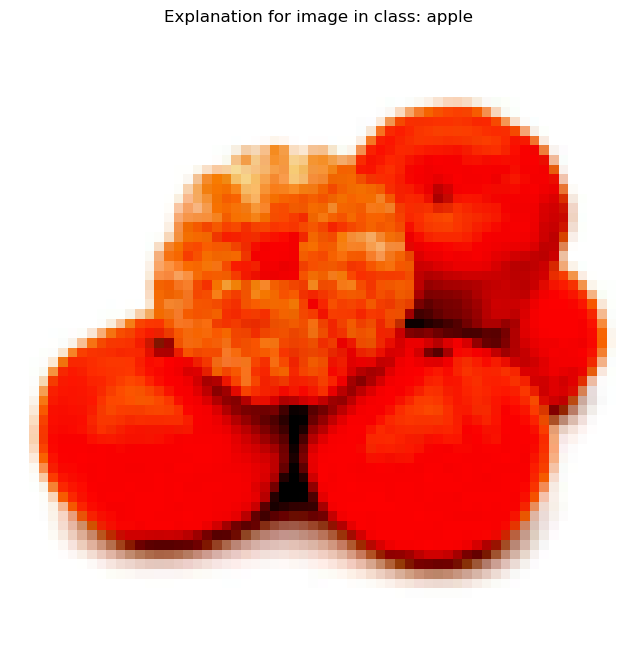

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


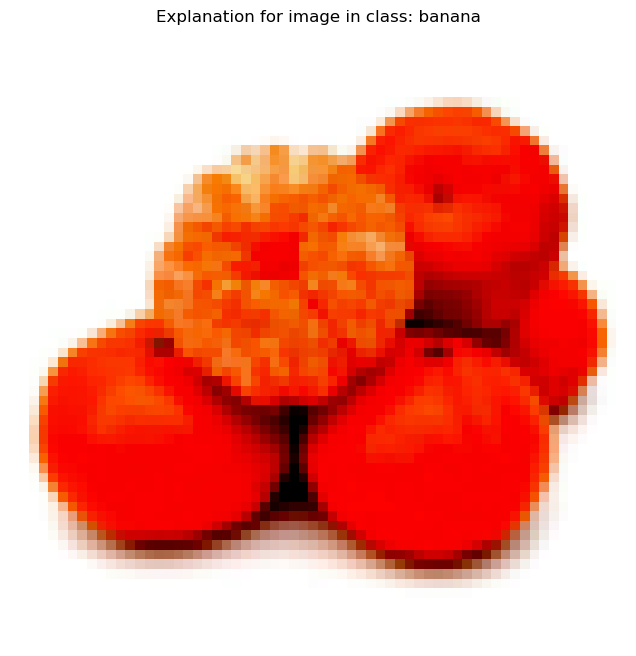

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


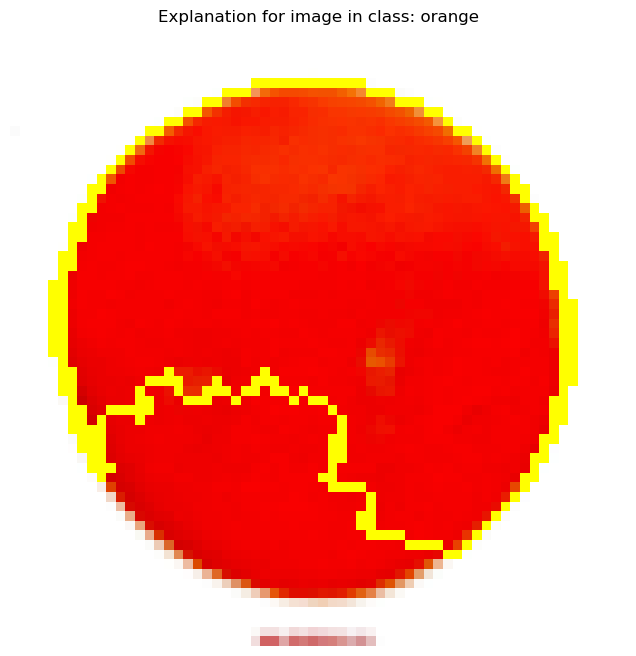

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


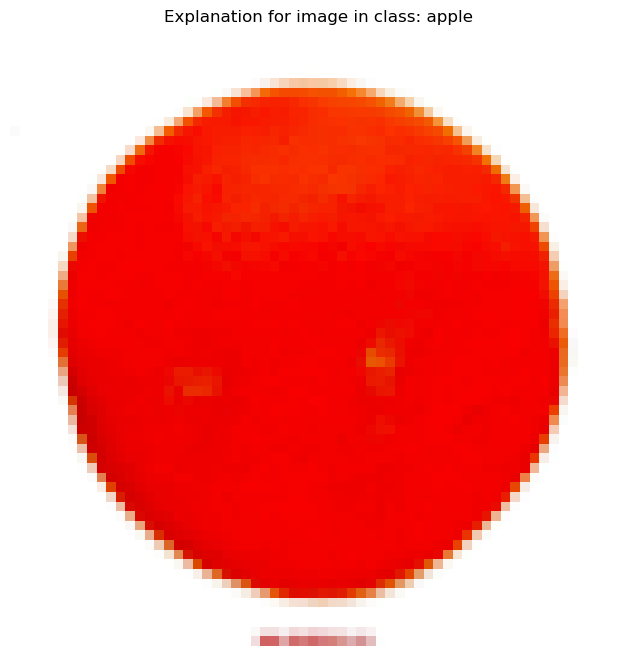

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


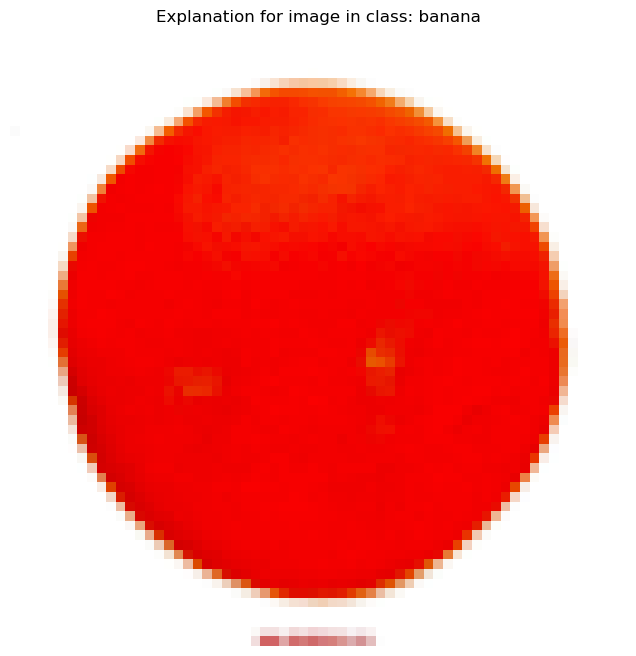

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


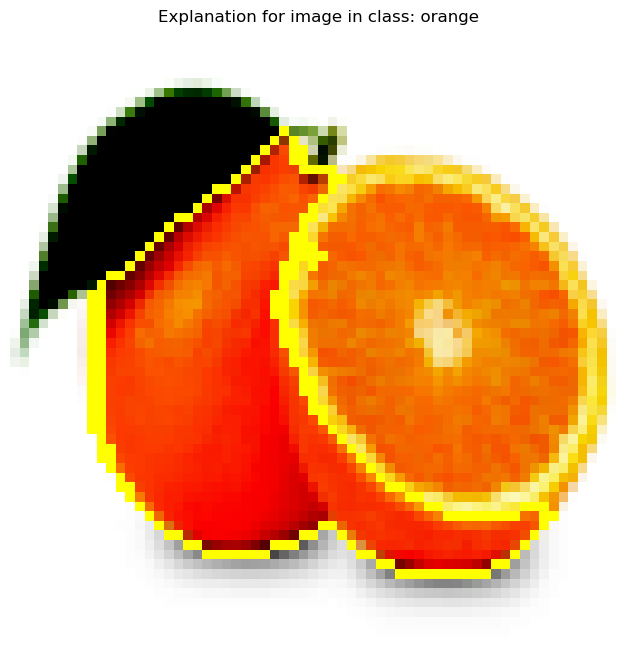

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


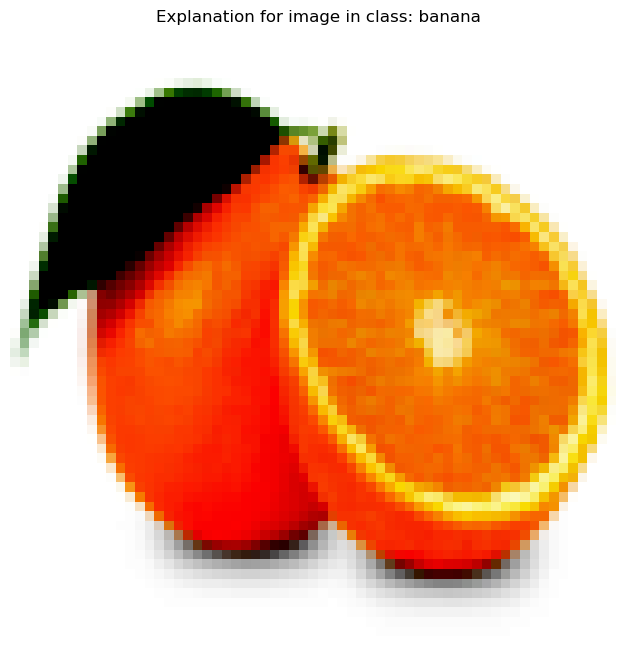

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


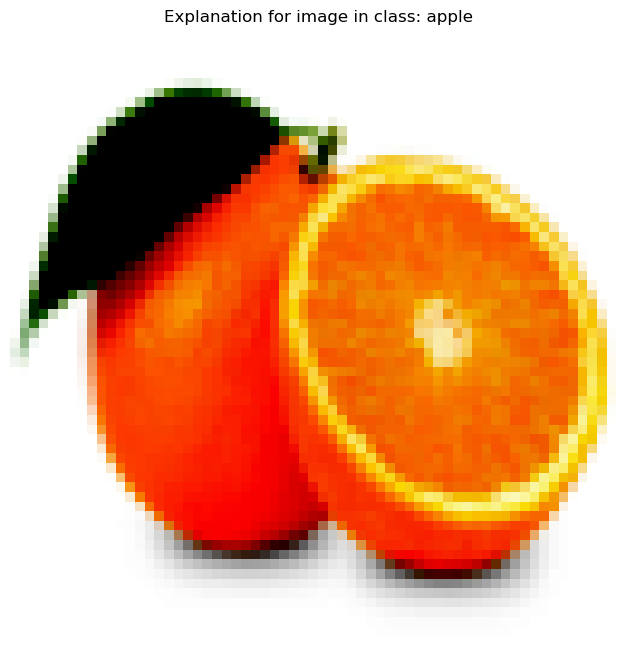

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


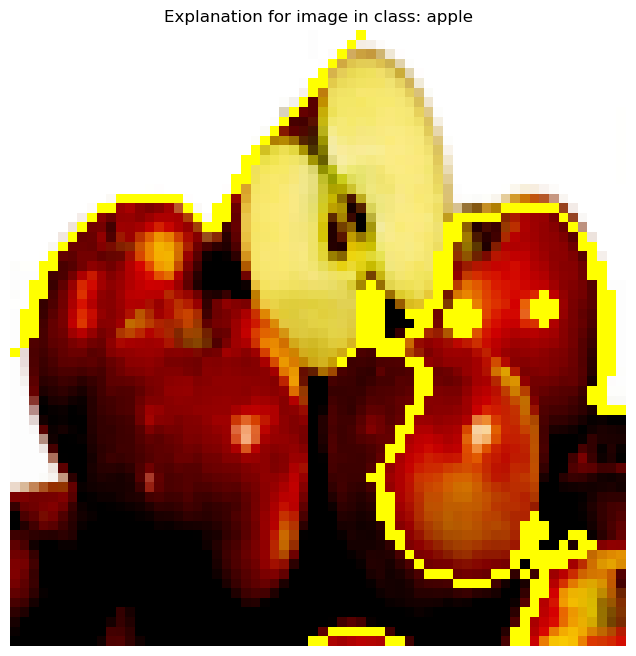

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


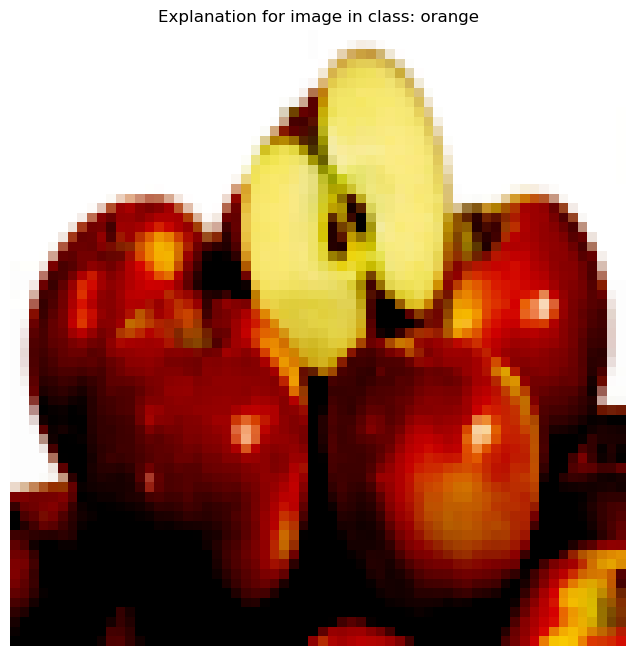

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


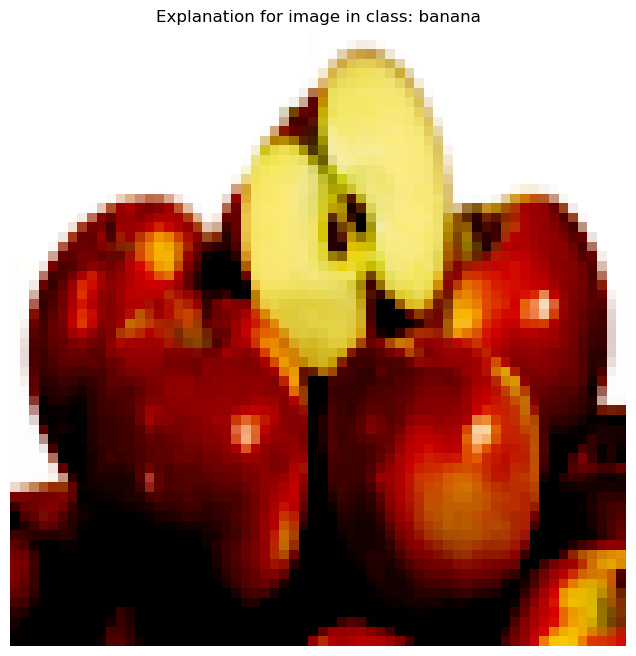

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


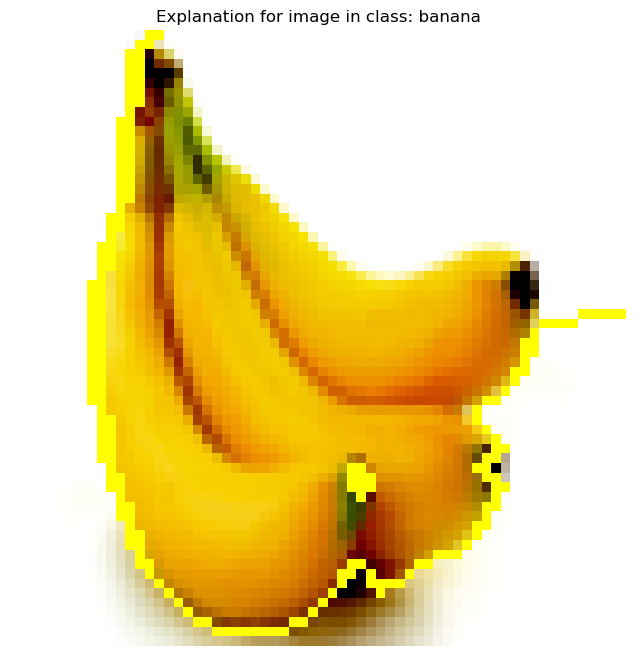

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


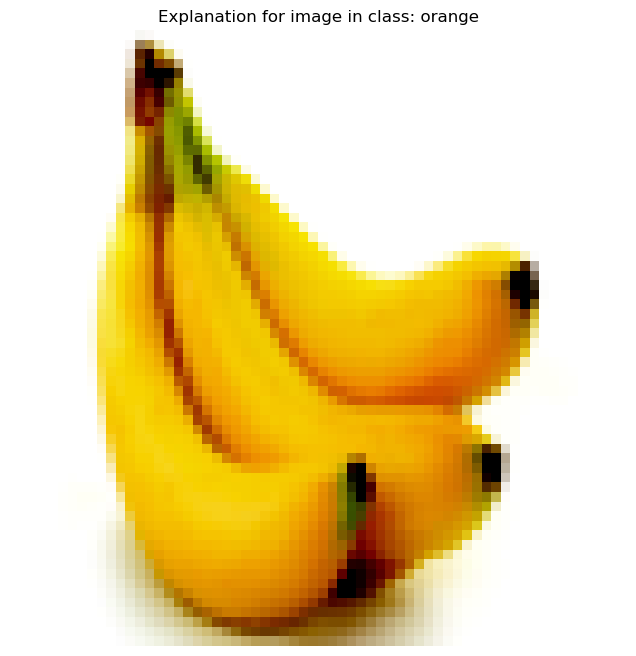

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


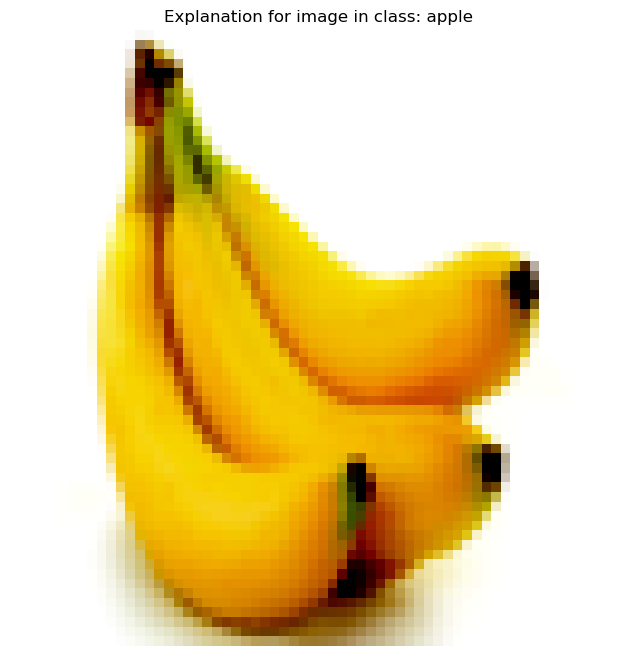

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


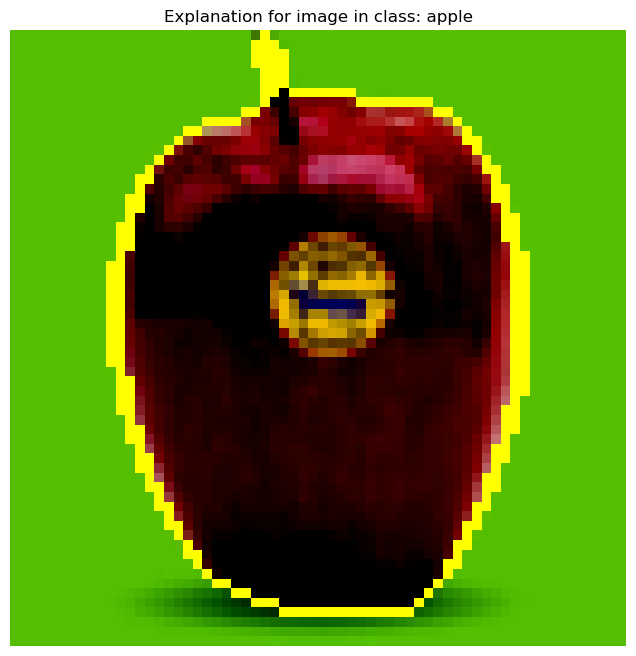

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


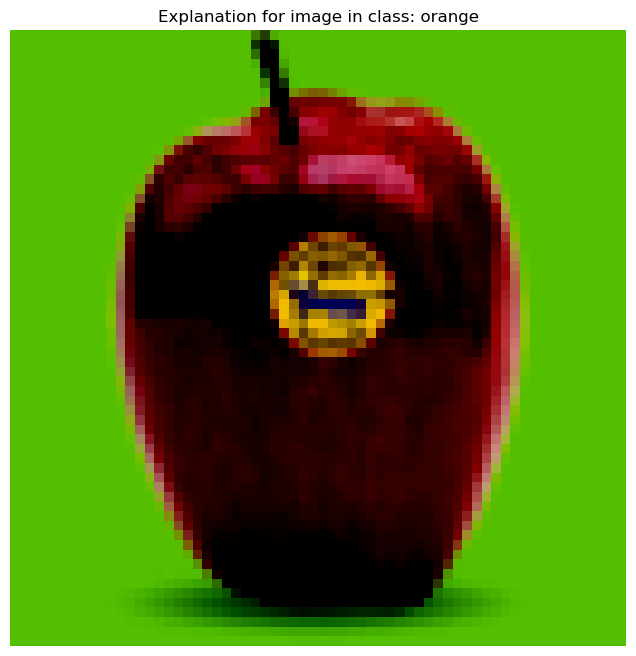

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


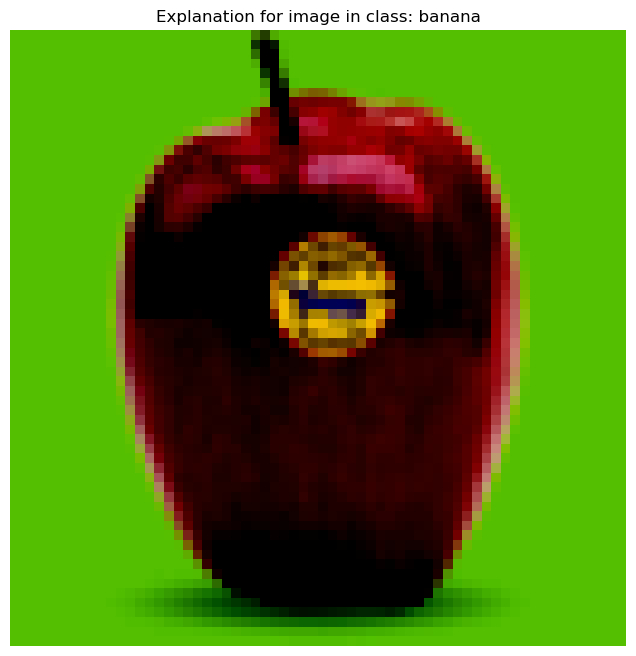

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


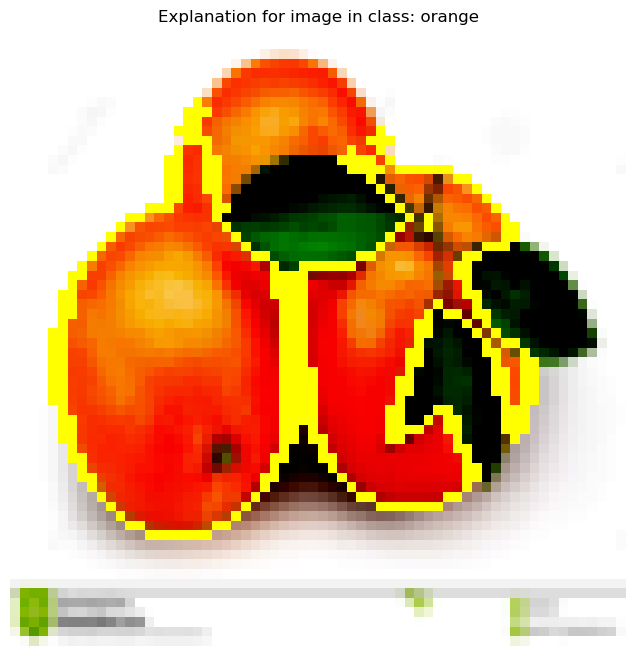

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


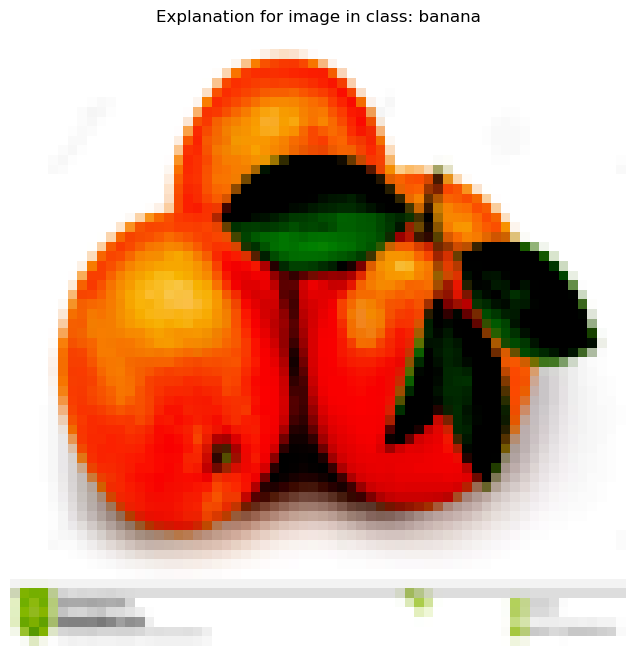

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


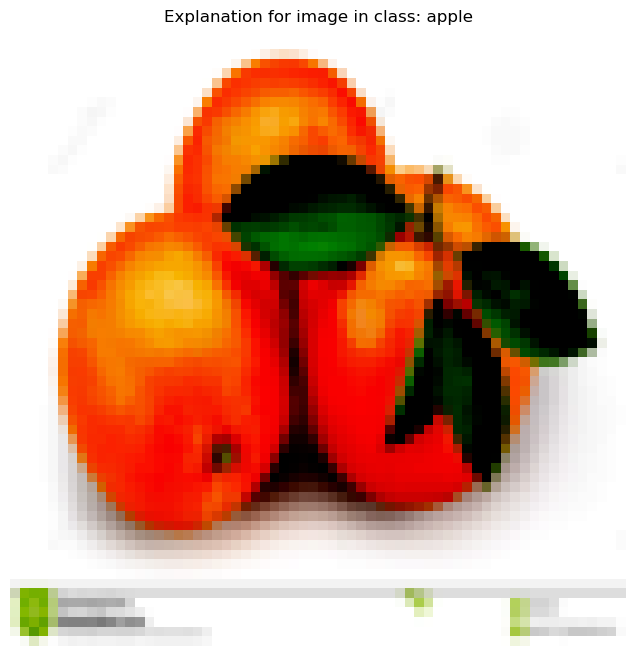

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


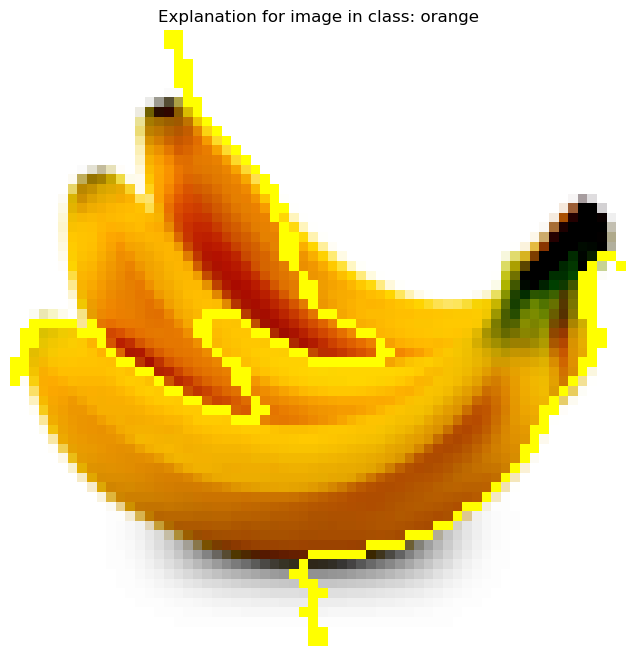

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


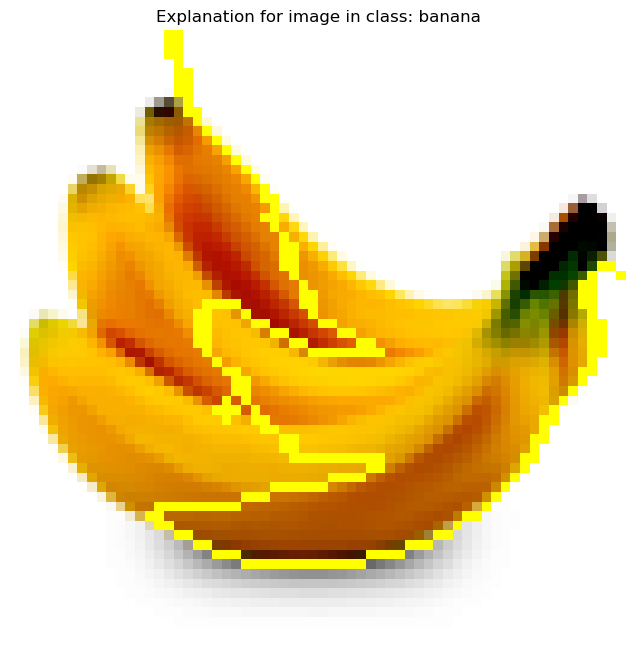

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


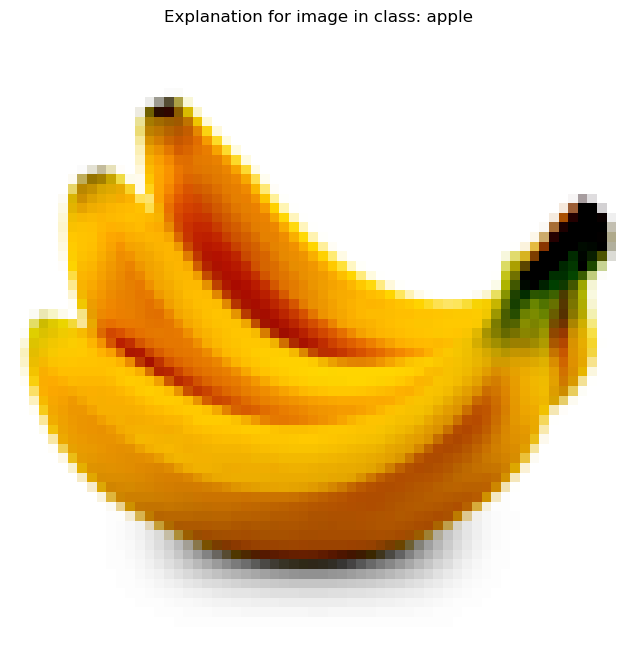

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


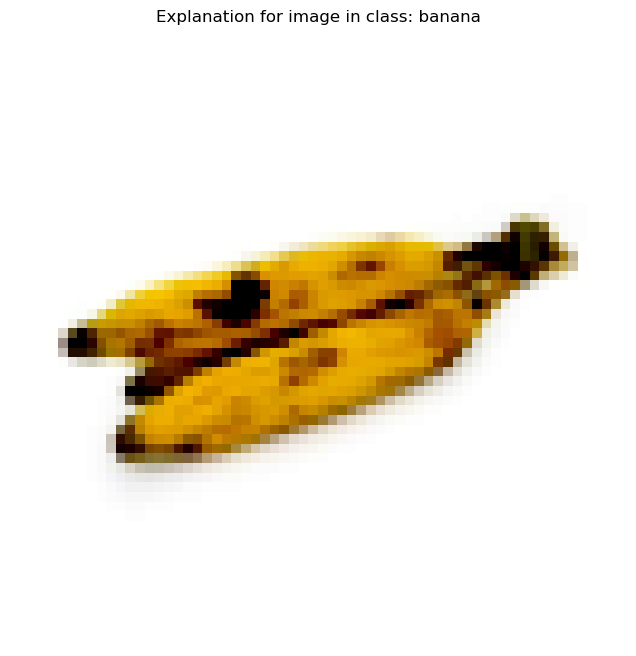

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


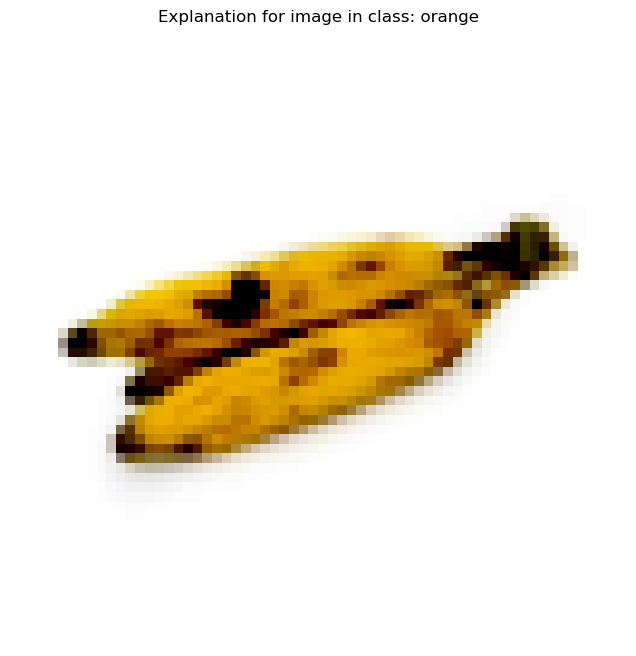

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


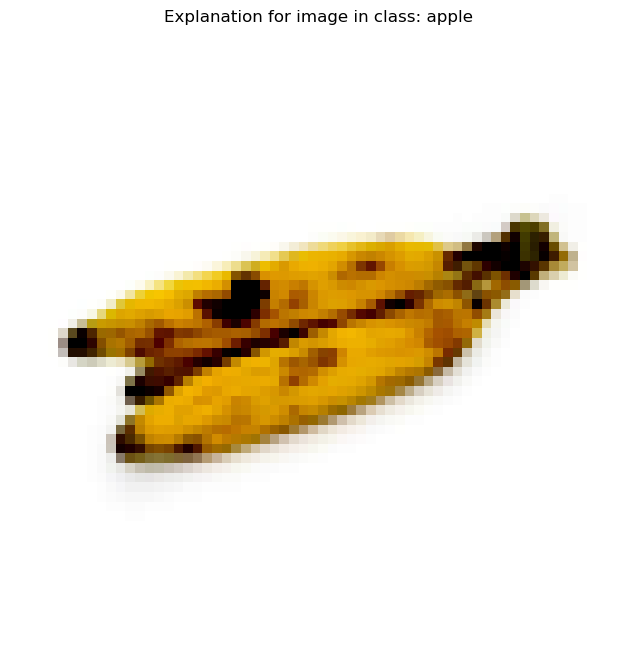

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


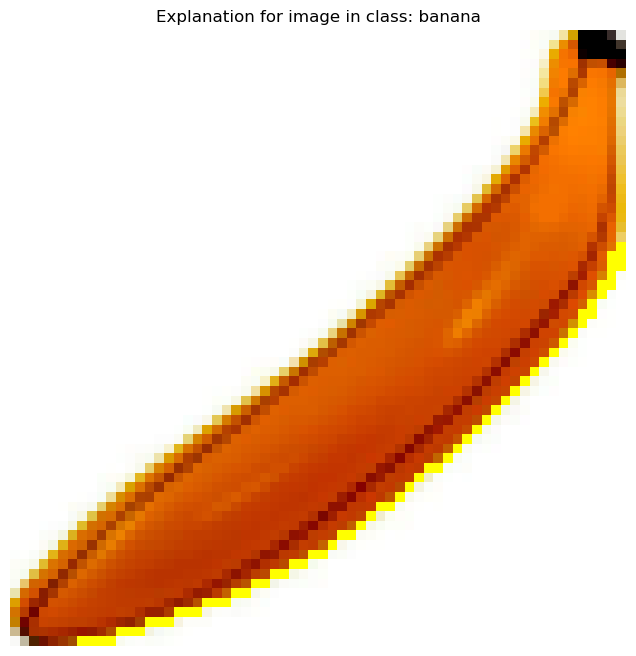

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


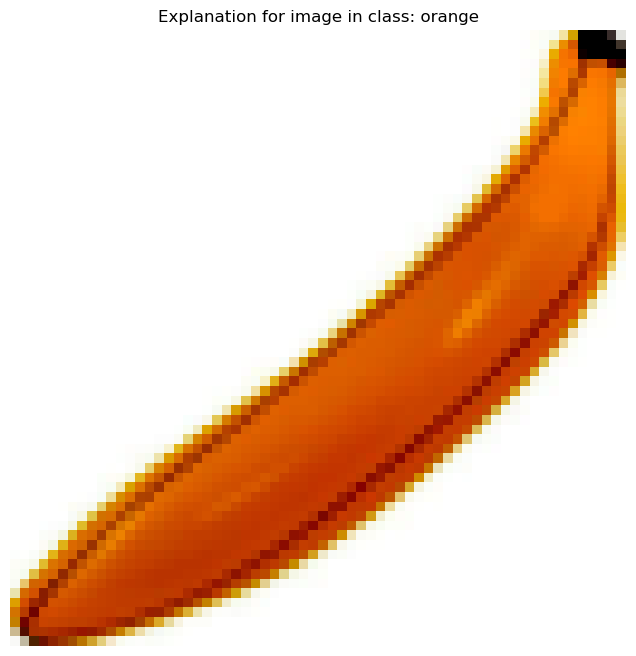

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


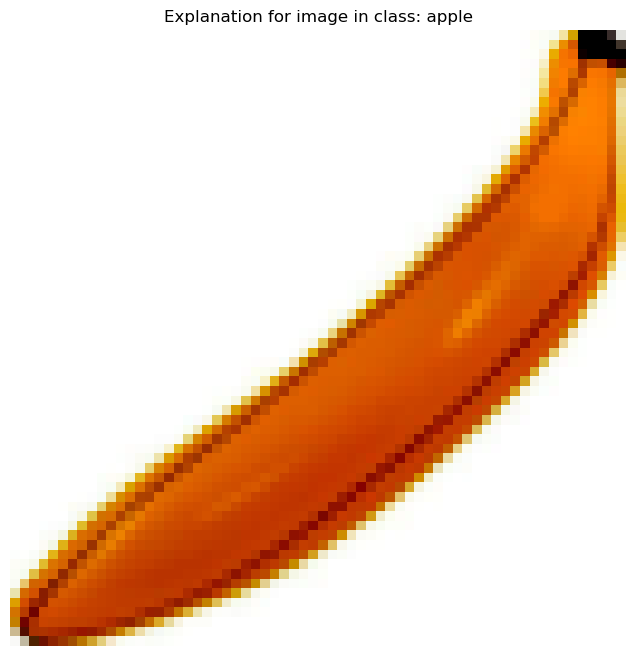

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


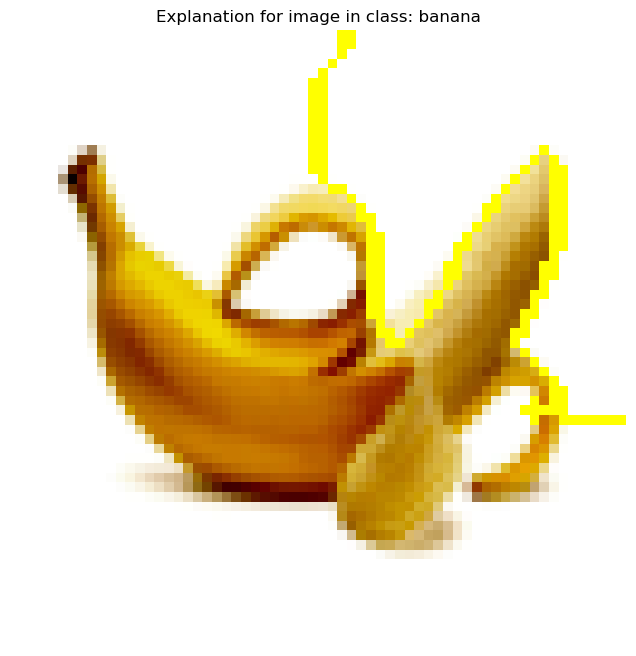

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


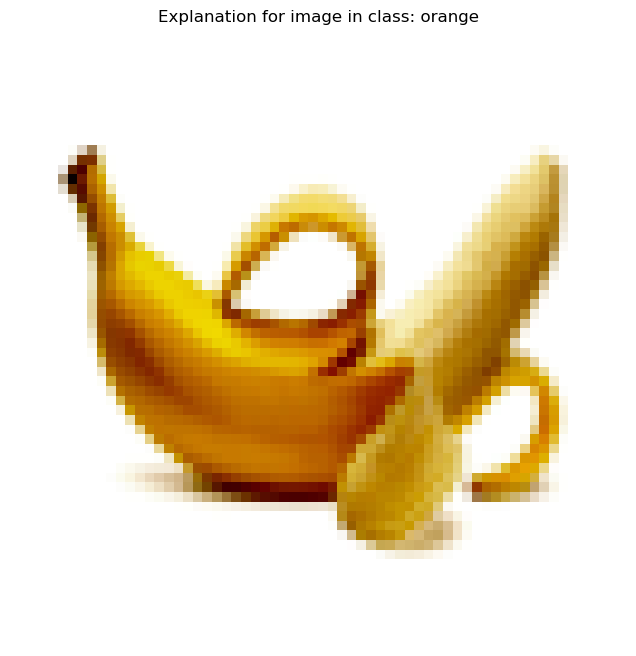

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


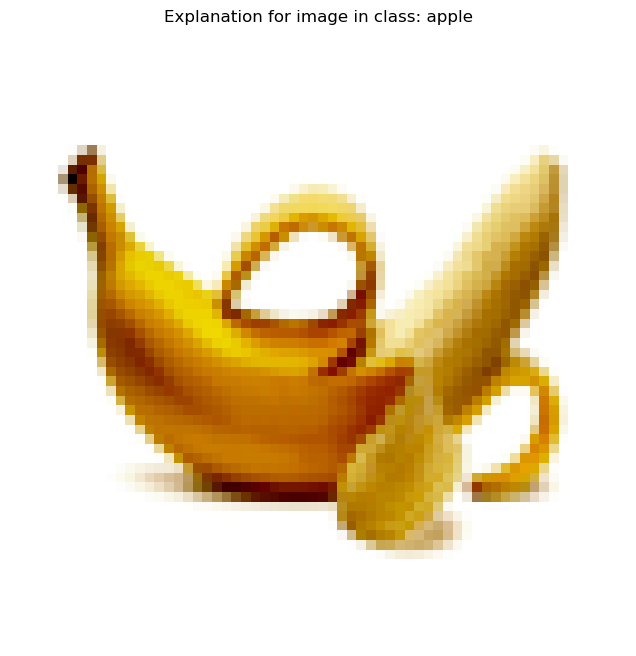

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


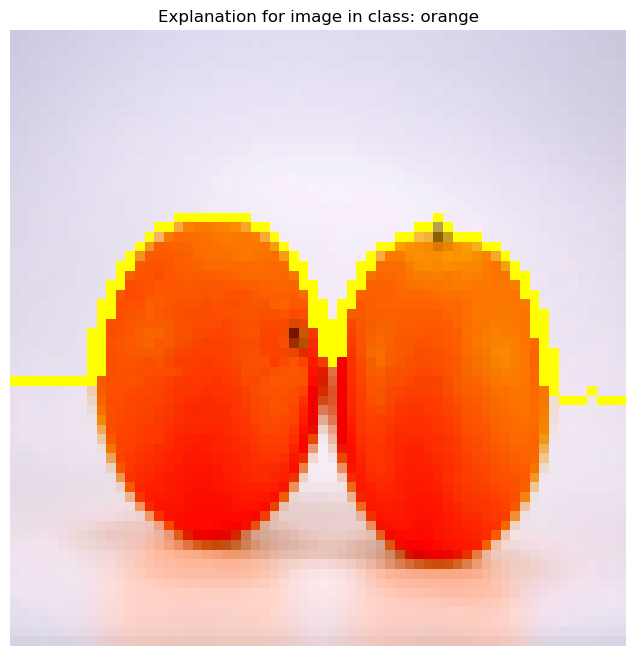

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


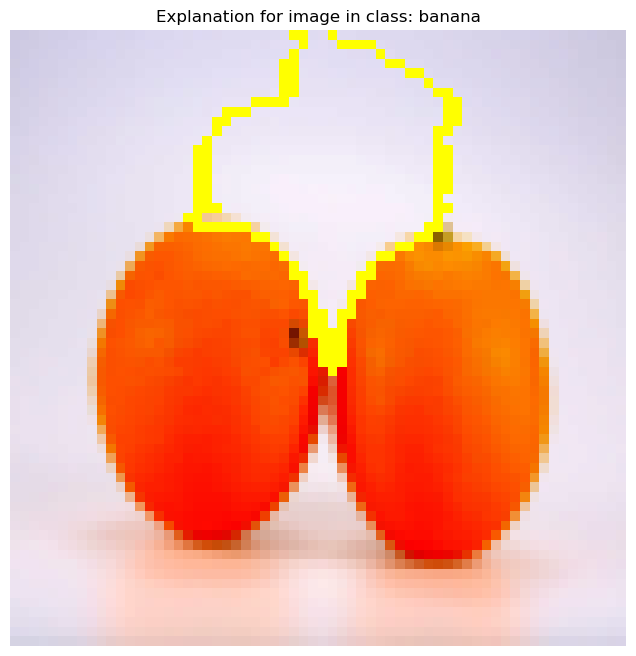

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


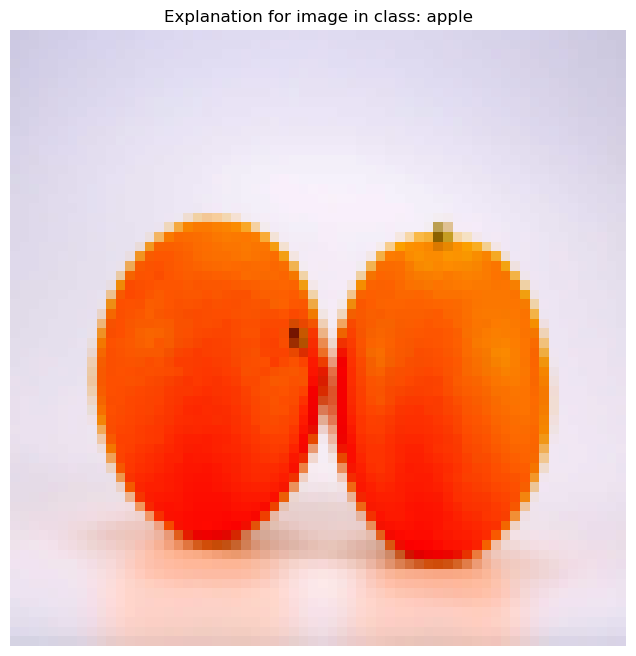

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


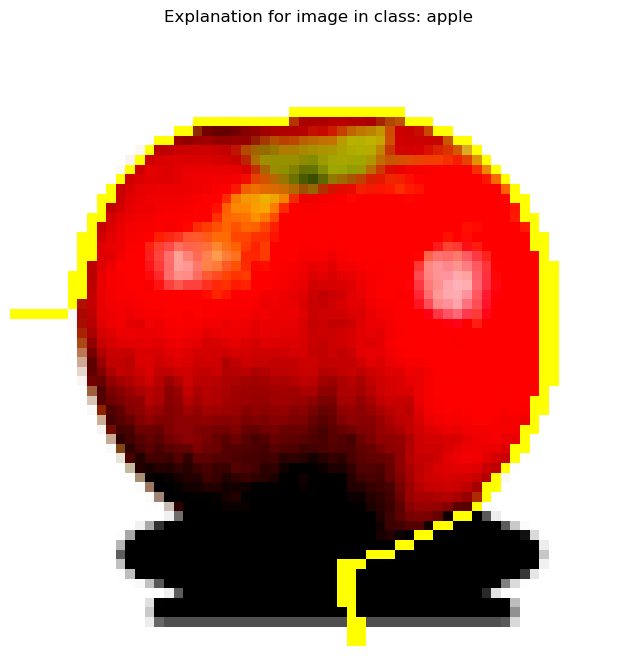

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


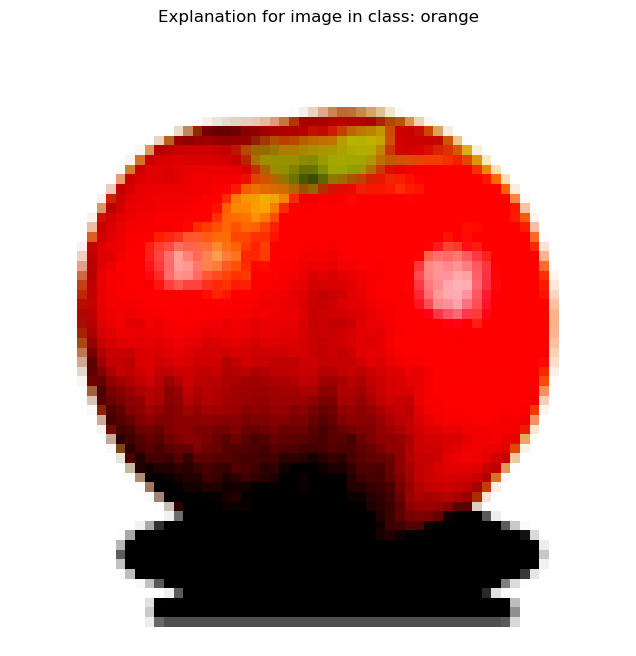

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


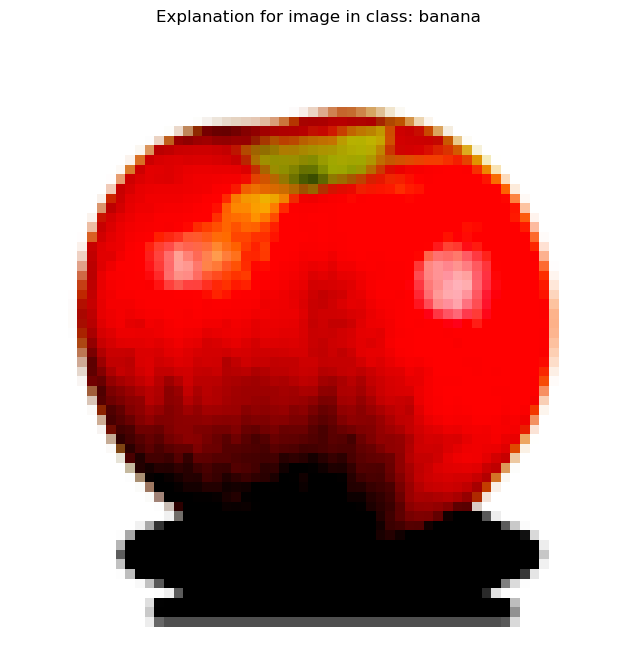

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


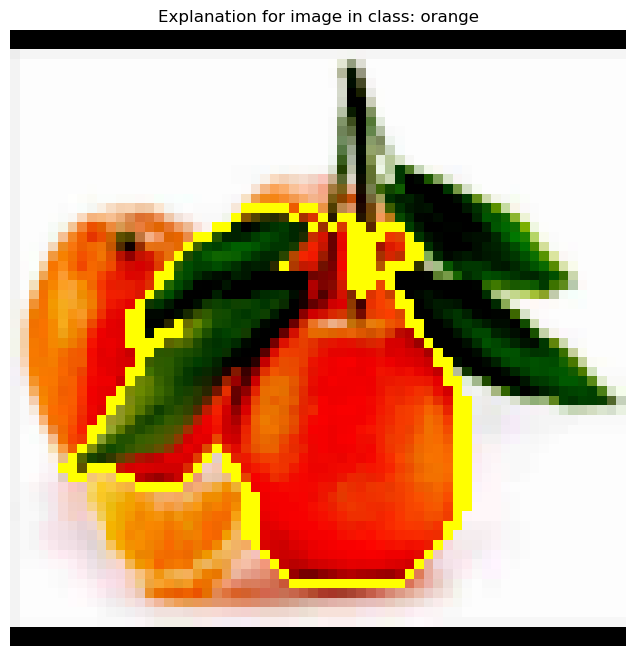

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


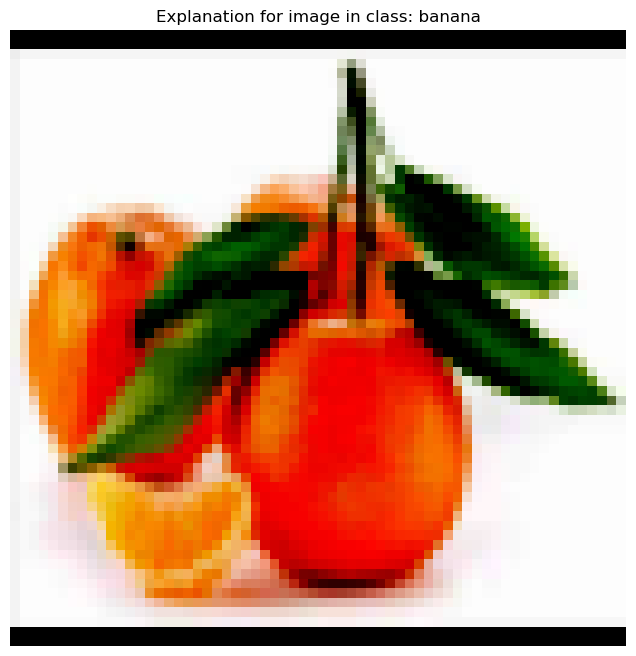

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


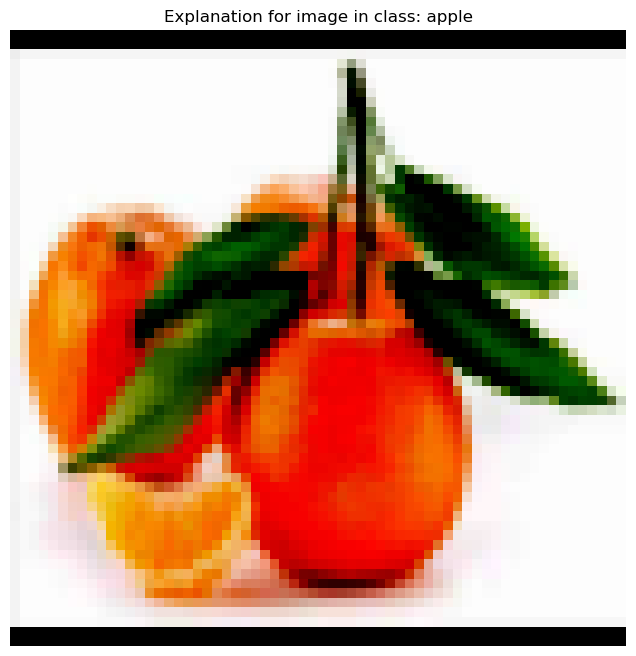

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


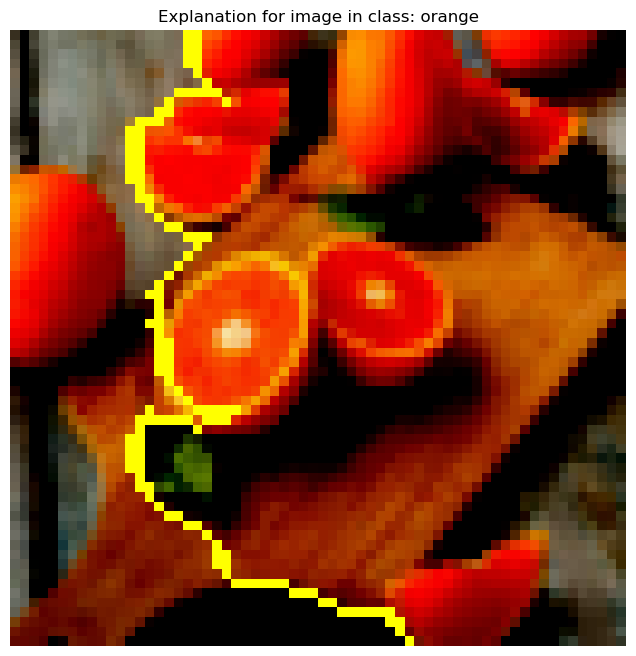

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


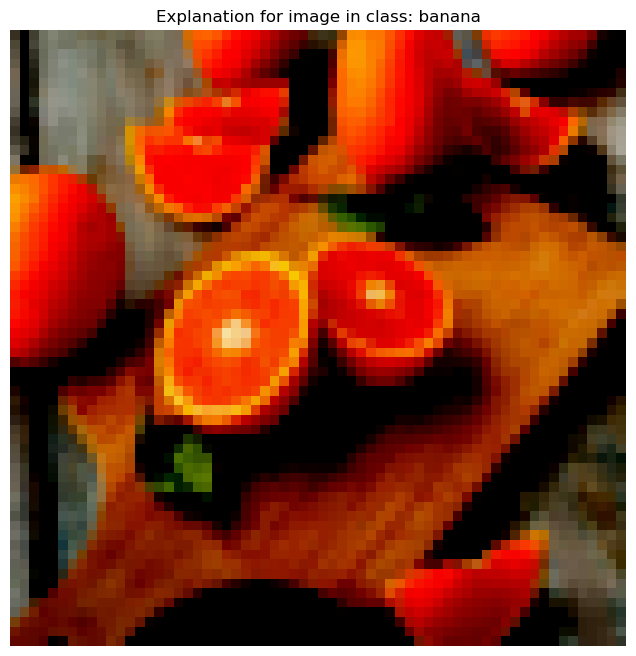

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


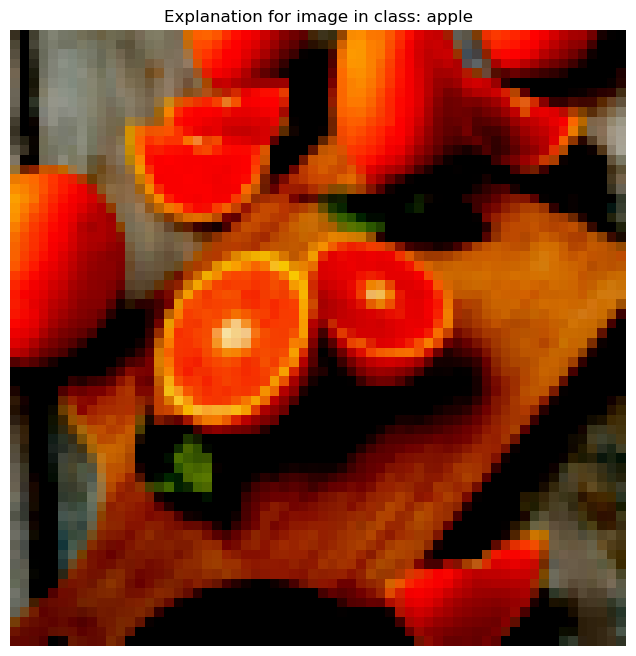

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


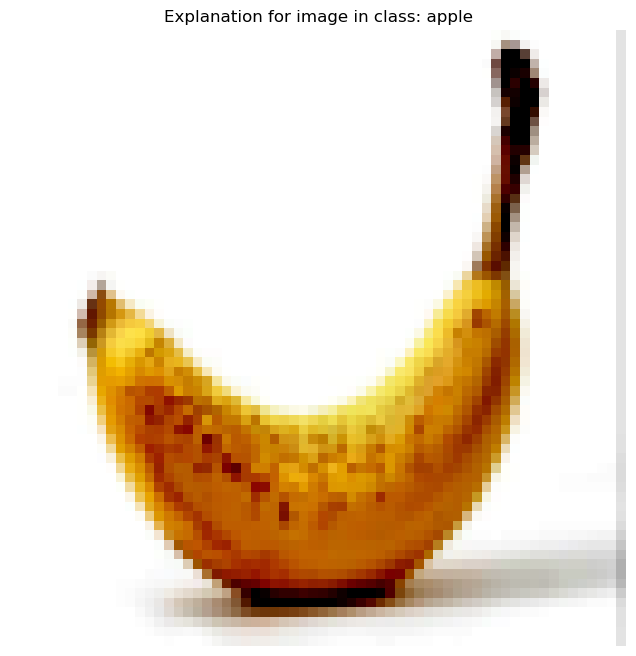

In [35]:
# Model Explainability


dataset = datasets.ImageFolder(root='test', transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
class_names = dataset.classes 

def lime_e(model, data_loader, class_names, device='cpu'):
    model.eval()

    for inputs, labels in data_loader:
        sample_data = inputs.to(device) 
        label = labels.item()

        image = sample_data[0].cpu().numpy().transpose(1, 2, 0)

        def predict_fn(images):
            model_input = torch.tensor(images.transpose(0, 3, 1, 2)).float().to(device)
            model_input = model_input.contiguous()
            outputs = model(model_input)
            probabilities = torch.softmax(outputs, dim=1)
            return probabilities.detach().cpu().numpy()


        explainer = lime_image.LimeImageExplainer()

        explanation = explainer.explain_instance(
            image,
            predict_fn,
            top_labels=len(class_names),
            hide_color=0,
            num_samples=1000
        )

        for class_idx in explanation.top_labels:
            temp, mask = explanation.get_image_and_mask(
                label=class_idx,
                positive_only=True,
                hide_rest=False,
                num_features=5,
                min_weight=0.1
            )
            plt.figure(figsize=(8, 8))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f"Explanation for image in class: {class_names[class_idx]}")
            plt.axis("off")
            plt.show()

        #break  

explain_with_lime_for_folder_structure(model, data_loader, class_names)


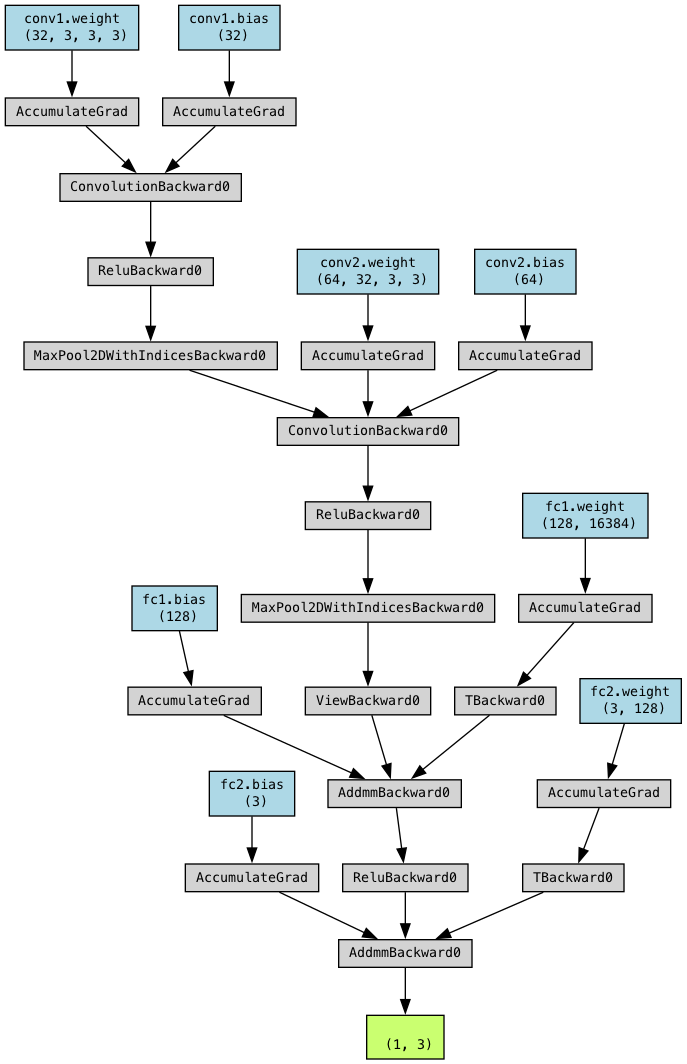

In [55]:
# Model Architecture
x = torch.randn(1, 3, 64, 64)

dot = make_dot(model(x), params=dict(model.named_parameters()))


Image(dot.pipe(format="png"))